In [6]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'
import glob
import numpy as np
import pandas as pd
#from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec


In [7]:
## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def gwpstar(arr,coeff1,coeff2,gwp100):
    arr_init = coeff1*arr[0:19]*gwp100
    gwparr = np.copy(arr)
    gwparr[20:gwparr.shape[0]] = coeff1*(arr[20:arr.shape[0]]*gwp100)-coeff2*(arr[0:gwparr.shape[0]-20]*gwp100)
    gwparr[0:19] = arr_init
    return(gwparr)

#### ======== Set the paths ========####

# Path for netcdf files
data_path = 'C:/Users/mastr/Documents/LSCE/Carbon Budget'                         ## WINDOWS
#data_path = '/Users/mmastro/Documents/LSCE/Carbon Budget'               ## MAC OS

# Path for the output files (images, etc)
out_path = "C:/Users/mastr/Documents/LSCE/RESULTS/Carbon_Budget_BETA&Q10_COU"
#out_path = '/Users/mmastro/Documents/LSCE/RESULTS'


## Constants
MttoGt = 0.001
CtoCO2 = 44/12
NtoN2O = 44/14
CO2toC = 12/44

## Standard Simulations with both CO2 and CH4 ANT Emissions

Open Data

In [8]:
path = "/CarbonBudget_IPSL_allGHG/new/"
all_files = glob.glob(os.path.join(data_path + path + "out_future_IPSL_allghg_1.5*.csv"))

dfs = list()
for f in all_files:
    data = pd.read_csv(f,  delim_whitespace=True)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['SCEN'] = os.path.basename(f).split('_')[4]
    data['TARGET'] = os.path.basename(f).split('_')[5]
    data['DR'] = os.path.basename(f).split('_')[6]
    dfs.append(data)

df_all_15 = pd.concat(dfs, ignore_index=True)

all_files = glob.glob(os.path.join(data_path + path + "out_future_IPSL_allghg_2*.csv"))

dfs = list()
for f in all_files:
    data = pd.read_csv(f,  delim_whitespace=True)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['SCEN'] = os.path.basename(f).split('_')[4]
    data['TARGET'] = os.path.basename(f).split('_')[5]
    data['DR'] = os.path.basename(f).split('_')[6]
    dfs.append(data)

df_all_20 = pd.concat(dfs, ignore_index=True)

# Convert TARGET and DR columns to integers
df_all_15.TARGET = df_all_15.TARGET.astype(int)
df_all_15.DR = df_all_15.DR.astype(int)

df_all_20.TARGET = df_all_20.TARGET.astype(int)
df_all_20.DR = df_all_20.DR.astype(int)

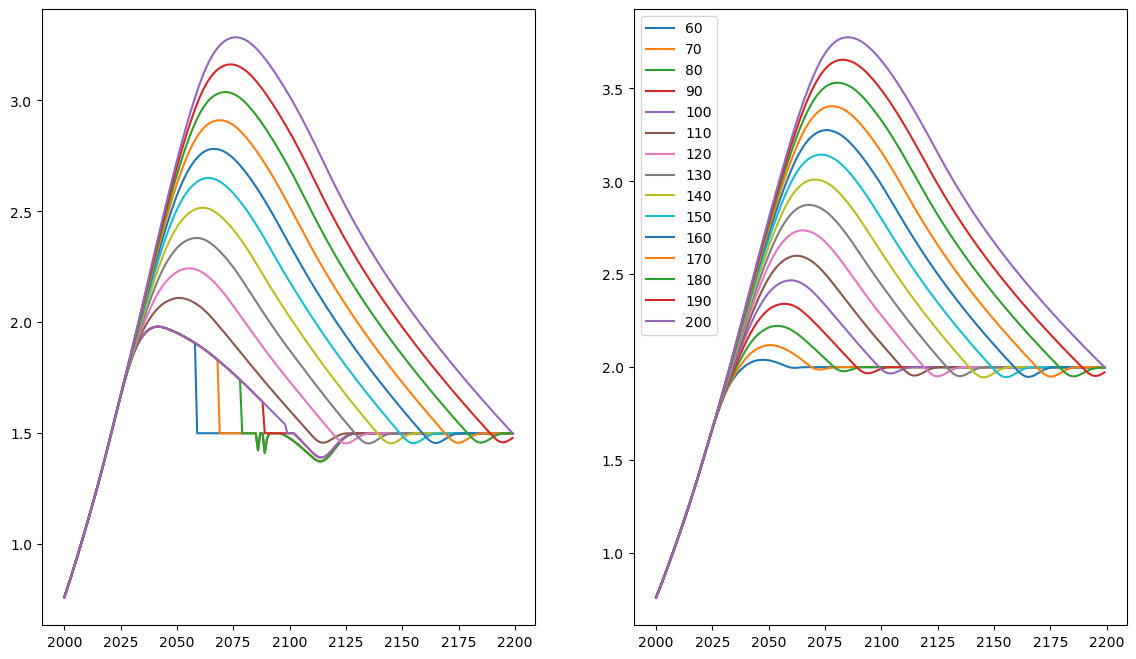

In [9]:
targets = sorted(map(int, (df_all_15["TARGET"].unique())))
targets_yrs = [element + 2000 for element in targets]

dr = 7

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(1, 2)

ax = fig.add_subplot(gs[0, 0])
for scn in list(targets):
    data = df_all_15[df_all_15["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["T2M"]
    ax.plot(year[0:200],em[0:200])

ax = fig.add_subplot(gs[0, 1])
for scn in list(targets):
    data = df_all_20[df_all_20["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["T2M"]
    ax.plot(year[0:200],em[0:200])

    ax.legend(targets)

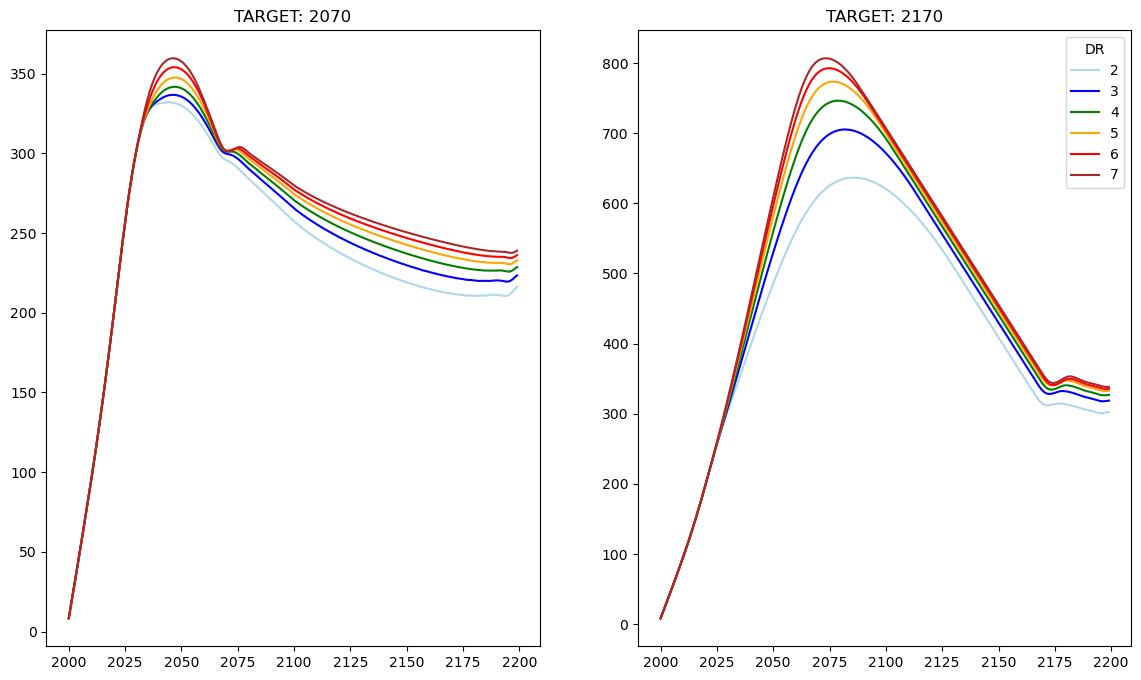

In [10]:
targets = sorted(map(int, (df_all_15["TARGET"].unique())))
drates = sorted(map(int, (df_all_15["DR"].unique())))

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(1, 2)

colors = ['lightblue','blue','green','orange','red','brown']
ax = fig.add_subplot(gs[0, 0])
for i,dr in enumerate(list(drates)):
    data = df_all_20[df_all_20["TARGET"] == 70]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    c = colors[i]
    ax.set_title("TARGET: 2070")
    ax.plot(year[0:200],em[0:200], color = c)

ax = fig.add_subplot(gs[0, 1])
for i,dr in enumerate(list(drates)):
    data = df_all_20[df_all_20["TARGET"] == 170]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    c = colors[i]
    ax.plot(year[0:200],em[0:200], color = c)
    ax.set_title("TARGET: 2170")
    ax.legend(drates, title = "DR")

### Disentangle OS Magnitude effect

In [11]:
# Define sets of targets and discount rates values

targets = sorted(df_all_15["TARGET"].unique()); targets
drates = sorted(df_all_15["DR"].unique()); drates


[2, 3, 4, 5, 6, 7]

Carbon and Temperature OS

In [12]:
df_OS_allghg_2 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'GHG_OS', 'CO2_OS', 'CH4_OS'])
df_OS_allghg_2.TARGET = targets
df_OS_allghg_2=df_OS_allghg_2.reindex(df_OS_allghg_2.index.repeat(len(drates)))

for scn in targets:

    # Assign DR values for every target
    df_OS_allghg_2.loc[df_OS_allghg_2['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_all_20[df_all_20["TARGET"] == scn].copy()

    overshoot = []; osco2 = []; osch4 = []
    t2m_os = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']

        # First data after T2M overshoot
        afteros = (data1.T2M[50:]<=2).idxmax()+1
        # Peak temperature
        peak = (data1.T2M[50:]).idxmax()

        # Threshold exceeding GHG Carbon Budget
        over = (data1['CUMGHG'][afteros] - data1['CUMGHG'][data1['CUMGHG'].index[0]+20])
        overco2 = (data1['CUMCO2'][afteros] - data1['CUMCO2'][data1['CUMCO2'].index[0]+20])
        overch4 = (data1['CUMCH4'][afteros] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])

        # Temperature overshoot
        t2m_over = (data1['T2M'][peak] - 2)

        overshoot.append(over)
        osco2.append(overco2)
        osch4.append(overch4)
        t2m_os.append(t2m_over)

    # Populate the dataframe with overshoot amounts
    df_OS_allghg_2.loc[df_OS_allghg_2['TARGET'] == scn, 'GHG_OS'] = np.array(overshoot)
    df_OS_allghg_2.loc[df_OS_allghg_2['TARGET'] == scn, 'CO2_OS'] = np.array(osco2)
    df_OS_allghg_2.loc[df_OS_allghg_2['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_allghg_2.loc[df_OS_allghg_2['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)

df_OS_allghg_2

,TARGET,DR,T2M_OS,GHG_OS,CO2_OS,CH4_OS
0,60,2,0.0188,53.742057,110.0031,-56.261043
0,60,3,0.0227,51.55957,112.882,-61.32243
0,60,4,0.0267,49.661605,114.5768,-64.915195
0,60,5,0.0297,48.13995,115.03,-66.89005
0,60,6,0.0331,46.631309,115.0423,-68.410991
...,...,...,...,...,...,...
14,200,3,1.5554,262.702946,168.1792,94.523746
14,200,4,1.644,269.421337,178.0522,91.369137
14,200,5,1.7027,273.39321,184.5303,88.86291
14,200,6,1.7444,275.607131,188.7369,86.870231


In [13]:
df_OS_allghg_15 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'GHG_OS', 'CO2_OS', 'CH4_OS'])
df_OS_allghg_15.TARGET = targets
df_OS_allghg_15=df_OS_allghg_15.reindex(df_OS_allghg_15.index.repeat(len(drates)))

for scn in targets:

    # Assign DR values for every target
    df_OS_allghg_15.loc[df_OS_allghg_15['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_all_15[df_all_15["TARGET"] == scn].copy()

    overshoot = []
    osco2 = []
    osch4 = []
    t2m_os = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']

        # First data after T2M overshoot
        afteros = (data1.T2M[50:]<=1.5).idxmax()+1
        # Peak temperature
        peak = (data1.T2M[50:]).idxmax()

        # Threshold exceeding Carbon Budget
        over = (data1['CUMGHG'][afteros] - data1['CUMGHG'][data1['CUMGHG'].index[0]+20])
        overco2 = (data1['CUMCO2'][afteros] - data1['CUMCO2'][data1['CUMCO2'].index[0]+20])
        overch4 = (data1['CUMCH4'][afteros] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])

        # Temperature overshoot
        t2m_over = (data1['T2M'][peak] - 1.5)

        overshoot.append(over)
        osco2.append(overco2)
        osch4.append(overch4)
        t2m_os.append(t2m_over)

    # Populate the dataframe with overshoot amounts
    df_OS_allghg_15.loc[df_OS_allghg_15['TARGET'] == scn, 'GHG_OS'] = np.array(overshoot)
    df_OS_allghg_15.loc[df_OS_allghg_15['TARGET'] == scn, 'CO2_OS'] = np.array(osco2)
    df_OS_allghg_15.loc[df_OS_allghg_15['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_allghg_15.loc[df_OS_allghg_15['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)

df_OS_allghg_15

,TARGET,DR,T2M_OS,GHG_OS,CO2_OS,CH4_OS
0,60,2,0.4527,-0.603234,76.9825,-77.585734
0,60,3,0.4527,-0.603234,76.9825,-77.585734
0,60,4,0.4527,-0.603234,76.9825,-77.585734
0,60,5,0.4527,-0.603234,76.9825,-77.585734
0,60,6,0.4527,-0.603234,76.9825,-77.585734
...,...,...,...,...,...,...
14,200,3,1.6015,-11.800348,-99.3307,87.530352
14,200,4,1.6757,-7.433529,-91.1397,83.706171
14,200,5,1.7241,-4.860221,-85.5216,80.661379
14,200,6,1.7584,-3.529139,-81.7847,78.255561


Effect of OS magnitude on Carbon Budget

In [14]:
for scn in targets[5:]:

    # cb_diff = (df_OS_allghg_2[df_OS_allghg_2.TARGET == scn].CO2_OS.max() - df_OS_allghg_2[df_OS_allghg_2.TARGET == scn].CO2_OS.min())
    cb_diff = (df_OS_allghg_15[df_OS_allghg_15.TARGET == scn].CO2_OS.max() - df_OS_allghg_15[df_OS_allghg_15.TARGET == scn].CO2_OS.min())

    print(f"{cb_diff}")


3.11760000000001
11.11809999999997
18.623200000000196
24.309099999999674
28.410500000000226
31.332199999999844
32.94509999999984
34.13820000000014
34.68679999999986
34.755100000000965


In [15]:
df_OS_allghg_15

,TARGET,DR,T2M_OS,GHG_OS,CO2_OS,CH4_OS
0,60,2,0.4527,-0.603234,76.9825,-77.585734
0,60,3,0.4527,-0.603234,76.9825,-77.585734
0,60,4,0.4527,-0.603234,76.9825,-77.585734
0,60,5,0.4527,-0.603234,76.9825,-77.585734
0,60,6,0.4527,-0.603234,76.9825,-77.585734
...,...,...,...,...,...,...
14,200,3,1.6015,-11.800348,-99.3307,87.530352
14,200,4,1.6757,-7.433529,-91.1397,83.706171
14,200,5,1.7241,-4.860221,-85.5216,80.661379
14,200,6,1.7584,-3.529139,-81.7847,78.255561


Barplot of Carbon Budget & plots of temperature pathways  

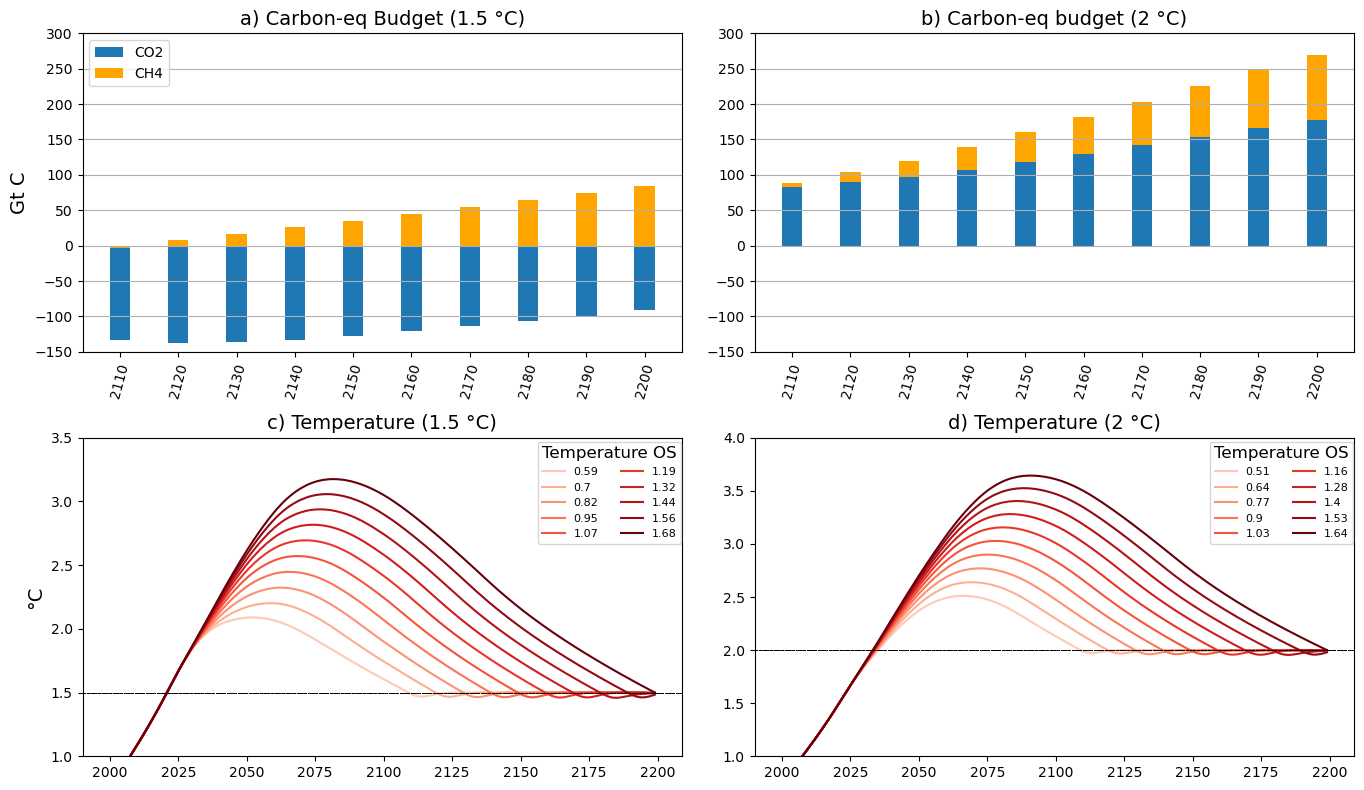

In [16]:
## -------------------- PLOT ---------------------##

x = np.arange(len(targets[5:]))  # the label locations
width = 0.35  # the width of the bars

# Plot configuration
width_inch = 14
height_inch = 8

fig, ax = plt.subplots(2, 2, figsize=(width_inch, height_inch))
title = 'ACC2 multi-gas simulation - Carbon Budget, IPSL emulation'

targets_plot = targets[5:].copy()

## -- FIRST PLOT
ax[0,0].bar(x[:] - width/2, df_OS_allghg_15[(df_OS_allghg_15.TARGET >= 110) & (df_OS_allghg_15.DR == 4)].CO2_OS, width, align='edge', label='CO2', color='tab:blue')
ax[0,0].bar(x[:] - width/2, df_OS_allghg_15[(df_OS_allghg_15.TARGET >= 110) & (df_OS_allghg_15.DR == 4)].CH4_OS, width, align='edge', label='CH4', color = 'orange')
# ax[0,0].bar(x[-1] - width/2, df_OS_allghg_15[(df_OS_allghg_15.TARGET == 200) & (df_OS_allghg_15.DR == 4)].CO2_OS, width, align='edge', color='tab:blue')
# ax[0,0].bar(x[-1] - width/2, df_OS_allghg_15[(df_OS_allghg_15.TARGET == 200) & (df_OS_allghg_15.DR == 4)].CH4_OS, width, bottom = df_OS_allghg_15[(df_OS_allghg_15.TARGET == 200) & (df_OS_allghg_15.DR == 4)].CO2_OS, align='edge',color = 'orange')
# Add some text for labels, title and custom x-axis tick labels, etc.
# ax[0,0].set_xlabel('Overshoot scenarios', size = 14)
ax[0,0].set_ylabel('Gt C', size = 14)
ax[0,0].set_xticks(x, targets_yrs[5:], rotation = 75)
ax[0,0].grid(axis = 'y')
ax[0,0].set_ylim(-150,300)
# Combine multiple axes labels in a single legend
lines, labels = ax[0,0].get_legend_handles_labels()
ax[0,0].legend(lines, labels, loc="upper left")
# ax[0,0].legend(OS_temp_15_mag, title = "OS magnitude", title_fontsize = 14,bbox_to_anchor=(0.65, 1),fontsize=8, ncol=2)

## -- SECOND PLOT
ax[0,1].bar(x - width/2, df_OS_allghg_2[(df_OS_allghg_2.TARGET >= 110) & (df_OS_allghg_2.DR == 4)].CO2_OS, width, align='edge', label='CO2', color='tab:blue')
ax[0,1].bar(x - width/2, df_OS_allghg_2[(df_OS_allghg_2.TARGET >= 110) & (df_OS_allghg_2.DR == 4)].CH4_OS, width, bottom = df_OS_allghg_2[(df_OS_allghg_2.TARGET >= 110) & (df_OS_allghg_2.DR == 4)].CO2_OS, align='edge', label='CH4', color = 'orange')
# Add some text for labels, title and custom x-axis tick labels, etc.
# ax[0,1].set_xlabel('Overshoot scenarios', size = 14)
# ax[0,1].set_ylabel('Mt C (CO2)')
ax[0,1].set_xticks(x, targets_yrs[5:], rotation = 75)
ax[0,1].grid(axis = 'y')
ax[0,1].set_ylim(-150,300)
# Combine multiple axes labels in a single legend
# lines, labels = ax[0,1].get_legend_handles_labels()

## --  THIRD PLOT
color = iter(cm.Reds(np.linspace(0.2, 1, len(x))))
for scn in targets_plot:
    c = next(color)
    data = df_all_15[(df_all_15.TARGET >= 110) & (df_all_15.DR == 4)] 
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    t2m = data["T2M"]
    ax[1,0].plot(year[0:200],t2m[0:200], color = c)
    ax[1,0].axhline(1.5, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
    ax[1,0].set_ylim(1,3.5)
    ax[1,0].set_ylabel('°C', size = 14)

legend2 = df_OS_allghg_15[(df_OS_allghg_15.TARGET >= 110) & (df_OS_allghg_15.DR == 4)].T2M_OS.astype(float).round(2)
ax[1,0].legend(legend2, title = "Temperature OS", title_fontsize = 12,bbox_to_anchor=(0.75, 0.65),fontsize=8, ncol=2)

## --  FOURTH PLOT
# color = plt.cm.Reds(np.linspace(0, 1, len(targets)))
color = iter(cm.Reds(np.linspace(0.2, 1, len(x))))
for i, scn in enumerate(targets_plot):
    c = next(color)
    data = df_all_20[(df_all_20.TARGET >= 110) & (df_all_20.DR == 4)] 
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    t2m = data["T2M"]
    ax[1,1].plot(year[0:200],t2m[0:200], color = c)
    ax[1,1].axhline(2, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
    ax[1,1].set_ylim(1,4)

legend3 = df_OS_allghg_2[(df_OS_allghg_2.TARGET >= 110) & (df_OS_allghg_2.DR == 4)].T2M_OS.astype(float).round(2)
ax[1,1].legend(legend3, title = "Temperature OS", title_fontsize = 12,bbox_to_anchor=(0.75, 0.65),fontsize=8, ncol=2)

ax[0,0].set_title('a) Carbon-eq Budget (1.5 °C)', size = 14)
ax[0,1].set_title('b) Carbon-eq budget (2 °C)', size = 14)
ax[1,0].set_title('c) Temperature (1.5 °C)', size = 14)
ax[1,1].set_title('d) Temperature (2 °C)', size = 14)


fig.subplots_adjust(bottom=0.2)
# fig.suptitle(title, size = 16)
fig.tight_layout()

#ax.bar_label(co215, padding=3)
#ax.bar_label(ch415, padding=3)

# output file
# output_file = os.path.join(out_path,title.replace(' ','_')) + "_allghg_stack_Threshold_return_budget.png"

# save the output file
# plt.savefig(output_file)
plt.show()
plt.close()

## Simulations with alternate fixed CH4 and CO2 emissions

Here ACC2 acts as an Emulator of ESMs

### Open Data

Please note that CH4 only 1.5 °C simulations are run until 2300, rather than 2500

In [17]:
path = "/CarbonBudget_IPSL_singleGHG/new/"
all_files = []
all_files = glob.glob(os.path.join(data_path + path +"out_future_IPSL_ch4_1.5_*.csv"))
# df = pd.concat((pd.read_csv(f, delim_whitespace=True) for f in all_files), ignore_index=True)

dfs = list()
for f in all_files:
    data = pd.read_csv(f,  delim_whitespace=True)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['SCEN'] = os.path.basename(f).split('_')[4]
    data['TARGET'] = os.path.basename(f).split('_')[5]
    data['DR'] = os.path.basename(f).split('_')[6]
    dfs.append(data)
df_ch4_15 = pd.concat(dfs, ignore_index=True)


all_files = glob.glob(os.path.join(data_path + path + "out_future_IPSL_ch4_2.0_*.csv"))
# df = pd.concat((pd.read_csv(f, delim_whitespace=True) for f in all_files), ignore_index=True)
dfs = list()
for f in all_files:
    data = pd.read_csv(f, delim_whitespace=True)
    data['SCEN'] = os.path.basename(f).split('_')[4]
    data['TARGET'] = os.path.basename(f).split('_')[5]
    data['DR'] = os.path.basename(f).split('_')[6]
    dfs.append(data)
df_ch4_20 = pd.concat(dfs, ignore_index=True)


all_files = glob.glob(os.path.join(data_path + path + "out_future_IPSL_co2_1.5_*.csv"))
# df = pd.concat((pd.read_csv(f, delim_whitespace=True) for f in all_files), ignore_index=True)
dfs = list()
for f in all_files:
    data = pd.read_csv(f, delim_whitespace=True)
    data['SCEN'] = os.path.basename(f).split('_')[4]
    data['TARGET'] = os.path.basename(f).split('_')[5]
    data['DR'] = os.path.basename(f).split('_')[6]
    dfs.append(data)
df_co2_15 = pd.concat(dfs, ignore_index=True)


all_files = glob.glob(os.path.join(data_path + path + "out_future_IPSL_co2_2.0_*.csv"))
# df = pd.concat((pd.read_csv(f, delim_whitespace=True) for f in all_files), ignore_index=True)
dfs = list()
for f in all_files:
    data = pd.read_csv(f, delim_whitespace=True)
    data['SCEN'] = os.path.basename(f).split('_')[4]
    data['TARGET'] = os.path.basename(f).split('_')[5]
    data['DR'] = os.path.basename(f).split('_')[6]
    dfs.append(data)
df_co2_20 = pd.concat(dfs, ignore_index=True)

# Convert TARGET and DR columns to integers
df_ch4_15.TARGET = df_ch4_15.TARGET.astype(int)
df_ch4_15.DR = df_ch4_15.DR.astype(int)
df_ch4_20.TARGET = df_ch4_20.TARGET.astype(int)
df_ch4_20.DR = df_ch4_20.DR.astype(int)

df_co2_15.TARGET = df_co2_15.TARGET.astype(int)
df_co2_15.DR = df_co2_15.DR.astype(int)
df_co2_20.TARGET = df_co2_20.TARGET.astype(int)
df_co2_20.DR = df_co2_20.DR.astype(int)

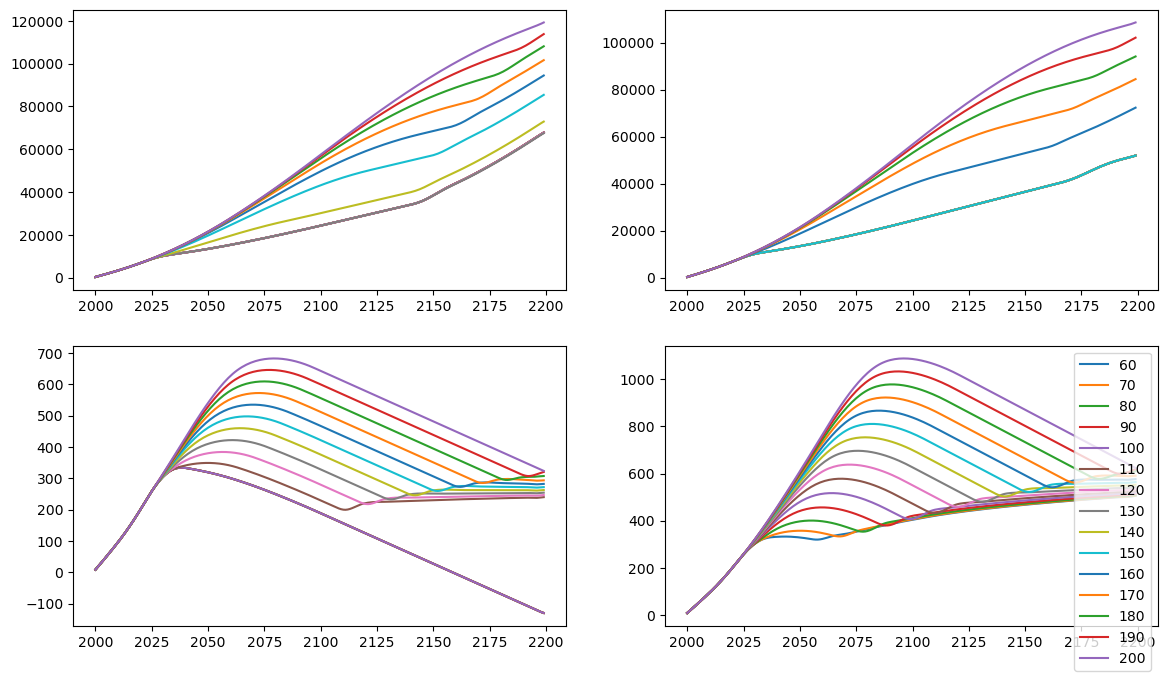

In [18]:
targets = sorted(map(int, (df_ch4_15["TARGET"].unique())))
drates = sorted(map(int, (df_ch4_15["DR"].unique())))
dr = 4

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
for scn in list(targets):
    data = df_ch4_15[df_ch4_15["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCH4"].cumsum()
    ax.plot(year[0:200],em[0:200])

ax = fig.add_subplot(gs[0, 1])
for scn in list(targets):
    data = df_ch4_20[df_ch4_20["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCH4"].cumsum()
    ax.plot(year[0:200],em[0:200])

ax = fig.add_subplot(gs[1, 0])
for scn in list(targets):
    data = df_co2_15[df_co2_15["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    ax.plot(year[0:200],em[0:200])

ax = fig.add_subplot(gs[1, 1])
for scn in list(targets):
    data = df_co2_20[df_co2_20["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    ax.plot(year[0:200],em[0:200])

    ax.legend(targets)

Text(0.5, 1.05, 'CO2-only simulations, 2°C - 2120 OS magnitude effect')

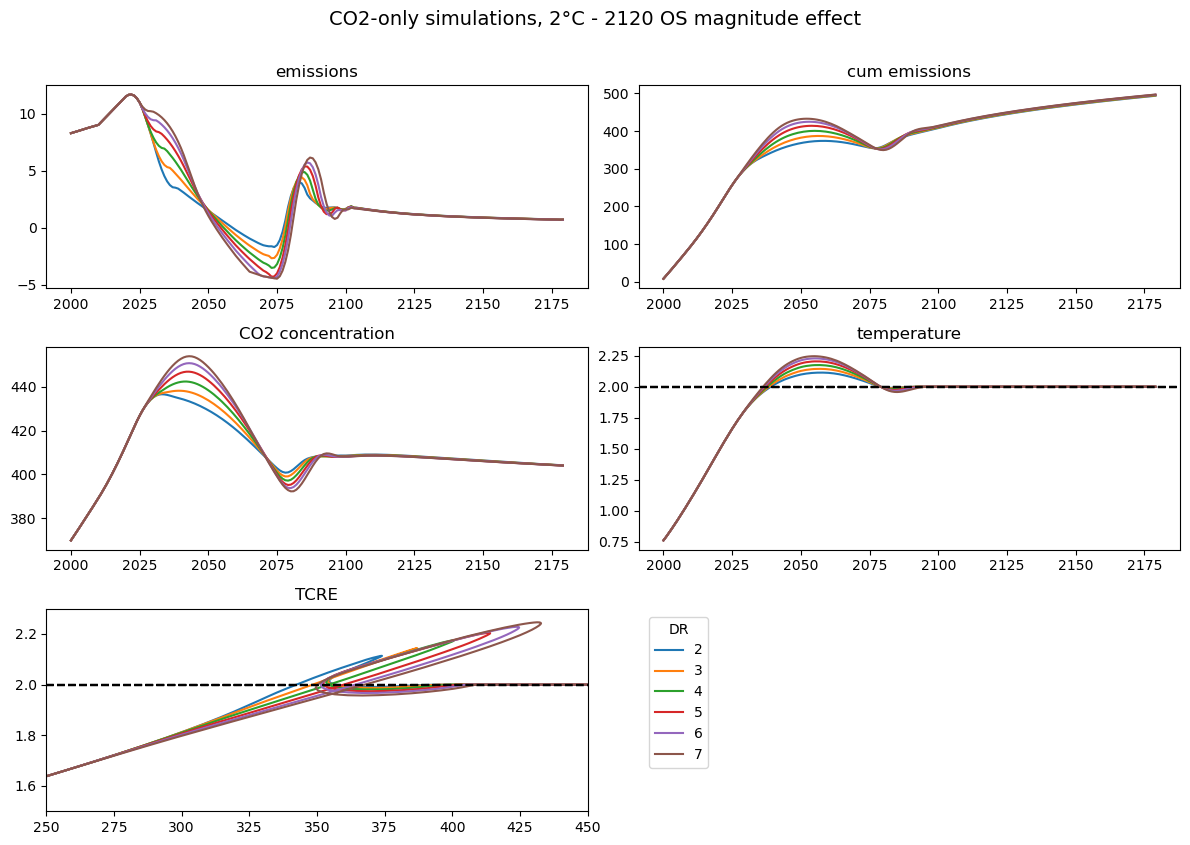

In [19]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2)

scn = 80

ax = fig.add_subplot(gs[0, 0])
for dr in list(drates[0:]):
    data = df_co2_20[df_co2_20["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    temp = data[data['DR'] == dr]["T2M"]
    em = data[data['DR'] == dr]["ANTCO2"]#.cumsum()
    ax.plot(year[0:180],em[0:180])
    ax.set_title("emissions")

ax = fig.add_subplot(gs[0, 1])
for dr in list(drates[0:]):
    data = df_co2_20[df_co2_20["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    temp = data[data['DR'] == dr]["T2M"]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    ax.plot(year[0:180],em[0:180])
    ax.set_title("cum emissions")

ax = fig.add_subplot(gs[1, 0])
for dr in list(drates[0:]):
    data = df_co2_20[df_co2_20["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    temp = data[data['DR'] == dr]["T2M"]
    em = data[data['DR'] == dr]["CONCO2"]
    ax.plot(year[0:180],em[0:180])
    ax.set_title("CO2 concentration")

ax = fig.add_subplot(gs[1, 1])
for dr in list(drates[0:]):
    data = df_co2_20[df_co2_20["TARGET"] == scn]
    year = data[data['DR'] == dr]["YEAR"]
    temp = data[data['DR'] == dr]["T2M"]
    ax.plot(year[0:180],temp[0:180])
    # ax.set_ylim(1.5,2.4)
    ax.axhline(2, linestyle = "dashed", color = "black")
    ax.set_title("temperature")

ax = fig.add_subplot(gs[2, 0])
for dr in list(drates[0:]):
    data = df_co2_20[df_co2_20["TARGET"] == scn]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    temp = data[data['DR'] == dr]["T2M"]
    ax.plot(em[0:180],temp[0:180])
    ax.axhline(2, linestyle = "dashed", color = "black")
    ax.set_xlim(250,450)
    ax.set_ylim(1.5,2.3)
    ax.set_title("TCRE")
fig.legend(drates, title = "DR", bbox_to_anchor =(0.6,0.3))

fig.tight_layout()
fig.suptitle("CO2-only simulations, 2°C - 2120 OS magnitude effect", y = 1.05, size = 14)

In [20]:
df_OS_co2_2 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'GHG_OS', 'CO2_OS', 'CH4_OS'])
df_OS_co2_2.TARGET = targets
df_OS_co2_2=df_OS_co2_2.reindex(df_OS_co2_2.index.repeat(len(drates)))


dfs = []
for scn in targets:

    # Assign DR values for every target
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_co2_20[df_co2_20["TARGET"] == scn].copy()

    overshoot = []; osco2 = []; osch4 = []; t2m_os = []; cbbefore = []; cbafter = []; over_tokarska19 = []; over_tokarska19ghg = []
    tcre_pos = []; tcre_neg = []; tcreplus_pos = []; tcreplus_neg = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative N2O emissions
        data1['CUMN2O'] = np.cumsum(data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']
        # Total GHG
        data1['GHG'] = (data1.ANTCO2) + (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC) + (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)

        ## CARBON BUDGET calculation (Tokarska, 2019)
        maxt2m = (data1["T2M"]).idxmax()
        before = (data1["T2M"].loc[:maxt2m] <= 2).iloc[::-1].idxmax()       # Last data before passing 2 °C
        after = (data1["T2M"].loc[maxt2m:] > 2).iloc[::-1].idxmax()+1       # First data after returning  to 2 °C
        maxcumem = (data1['CUMCO2'].loc[before:after].idxmax())
        cbbefore.append(data1['CUMCO2'].loc[before])
        cbafter.append(data1['CUMCO2'].loc[after])
        over_tokarska19.append(data1['CUMCO2'].loc[maxcumem] - data1['CUMCO2'].loc[before])


        # Threshold exceeding CARBON BUDGET
        over = (data1['CUMGHG'][after] - data1['CUMGHG'][data1['CUMGHG'].index[0]+20])
        overco2 = (data1['CUMCO2'][after] - data1['CUMCO2'][data1['CUMCO2'].index[0]+20])
        overch4 = (data1['CUMCH4'][after] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])
        # Temperature overshoot
        t2m_over = (data1['T2M'][maxt2m] - 2)
        # Populate the list
        overshoot.append(over)
        osco2.append(overco2)
        osch4.append(overch4)
        t2m_os.append(t2m_over)

        ## TCRE calculation
        # Peak cumghg
        maximum = (data1['GHG']<0).idxmax()
        # Lowest Peak cumghg
        minimum = data1[data1['YEAR'] == (2000 + scn -1)].index[0]
        # TCRE+ and TCRE-
        tplus_pos = (data1['T2M'][maximum]/data1['CUMGHG'][maximum])*1000
        tplus_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMGHG'][minimum] - data1['CUMGHG'][maximum]))*1000
        t_pos = (data1['T2M'][maximum]/data1['CUMCO2'][maximum])*1000
        t_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMCO2'][minimum] - data1['CUMCO2'][maximum]))*1000
        # Populate the list
        tcre_pos.append(t_pos)
        tcre_neg.append(t_neg)
        tcreplus_pos.append(tplus_pos)
        tcreplus_neg.append(tplus_neg)
            
        dfs.append(data1)

    # Populate the dataframe with overshoot amounts
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'GHG_OS'] = np.array(overshoot)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CO2_OS'] = np.array(osco2)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CBbefore_tok19'] = np.array(cbbefore)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CBafter_tok19'] = np.array(cbafter)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'OS_co2_tok19'] = np.array(over_tokarska19)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCRE+'] = np.array(tcre_pos)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCRE-'] = np.array(tcre_neg)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCREplus+'] = np.array(tcreplus_pos)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCREplus-'] = np.array(tcreplus_neg)
df_tcre_co2_2 = pd.concat(dfs, ignore_index=True)


df_OS_co2_2[df_OS_co2_2['TARGET'] == 160]

,TARGET,DR,T2M_OS,GHG_OS,CO2_OS,CH4_OS,CBbefore_tok19,CBafter_tok19,OS_co2_tok19,TCRE+,TCRE-,TCREplus+,TCREplus-
10,160,2,0.7717,399.055922,336.0759,-104.462878,369.1554,535.5359,391.0611,3.588252,3.234502,2.697342,5.122293
10,160,3,0.9192,407.363022,344.383,-104.462878,372.5449,543.8430,455.1259,3.504202,3.171373,2.706137,4.595729
10,160,4,1.0074,411.629522,348.6495,-104.462878,381.8217,548.1095,485.2486,3.456893,3.126374,2.700582,4.339431
10,160,5,1.0658,414.170622,351.1906,-104.462878,374.4768,550.6506,518.4328,3.430280,3.105623,2.698049,4.203028
10,160,6,1.1067,416.218322,353.2383,-104.462878,378.3524,552.6983,532.7150,3.409098,3.085969,2.692482,4.108722
10,160,7,1.1368,417.395022,354.415,-104.462878,381.0913,553.8750,543.5756,3.393015,3.067250,2.687542,4.037645


### Disentangle OS Magnitude effect

In [21]:
# Define sets of targets and discount rates values

targets = sorted(df_co2_20["TARGET"].unique()); targets
drates = sorted(df_co2_20["DR"].unique()); drates


[2, 3, 4, 5, 6, 7]

Carbon and Temperature OS and TCRE

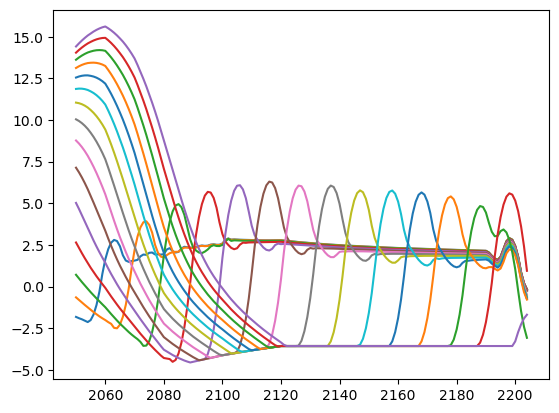

In [22]:
for scn in targets:
    data = df_co2_20[df_co2_20["TARGET"] == scn].copy()
    data1 = data[data["DR"] == 4]
    year = data[data['DR'] == 4]["YEAR"]
    data1['CUMCO2'] = (data1.ANTCO2)
    # Cumulative CH4 emissions
    data1['CUMCH4'] = (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
    # Cumulative N2O emissions
    data1['CUMN2O'] = (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
    # Cumulative CO2+CH4 emissions
    data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']

    plt.plot(year[50:205],data1['CUMGHG'][50:205])

#### CO2 Carbon Budget and TCRE

In [23]:
df_OS_co2_2 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'GHG_OS', 'CO2_OS', 'CH4_OS'])
df_OS_co2_2.TARGET = targets
df_OS_co2_2=df_OS_co2_2.reindex(df_OS_co2_2.index.repeat(len(drates)))


dfs = []
for scn in targets:

    # Assign DR values for every target
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_co2_20[df_co2_20["TARGET"] == scn].copy()

    overshoot = []; osco2 = []; osch4 = []; t2m_os = []
    tcre_pos = []; tcre_neg = []; tcreplus_pos = []; tcreplus_neg = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative N2O emissions
        data1['CUMN2O'] = np.cumsum(data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']
        # Total GHG
        data1['GHG'] = (data1.ANTCO2) + (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC) + (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)

        ## OVERSHOOT calculation
        # First data after T2M overshoot
        afteros = (data1.T2M[50:]<=2).idxmax()+1
        # Peak temperature
        peak = (data1.T2M[50:]).idxmax()
        # Threshold exceeding GHG Carbon Budget
        over = (data1['CUMGHG'][afteros] - data1['CUMGHG'][data1['CUMGHG'].index[0]+20])
        overco2 = (data1['CUMCO2'][afteros] - data1['CUMCO2'][data1['CUMCO2'].index[0]+20])
        overch4 = (data1['CUMCH4'][afteros] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])
        # Temperature overshoot
        t2m_over = (data1['T2M'][peak] - 2)
        # Populate the list
        overshoot.append(over)
        osco2.append(overco2)
        osch4.append(overch4)
        t2m_os.append(t2m_over)

        ## TCRE calculation
        # Peak cumghg
        maximum = (data1['GHG']<0).idxmax()
        # Lowest Peak cumghg
        minimum = data1[data1['YEAR'] == (2000 + scn -1)].index[0]
        # TCRE+ and TCRE-
        tplus_pos = (data1['T2M'][maximum]/data1['CUMGHG'][maximum])*1000
        tplus_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMGHG'][minimum] - data1['CUMGHG'][maximum]))*1000
        t_pos = (data1['T2M'][maximum]/data1['CUMCO2'][maximum])*1000
        t_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMCO2'][minimum] - data1['CUMCO2'][maximum]))*1000
        # Populate the list
        tcre_pos.append(t_pos)
        tcre_neg.append(t_neg)
        tcreplus_pos.append(tplus_pos)
        tcreplus_neg.append(tplus_neg)
            
        dfs.append(data1)

    # Populate the dataframe with overshoot amounts
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'GHG_OS'] = np.array(overshoot)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CO2_OS'] = np.array(osco2)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCRE+'] = np.array(tcre_pos)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCRE-'] = np.array(tcre_neg)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCREplus+'] = np.array(tcreplus_pos)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCREplus-'] = np.array(tcreplus_neg)
df_tcre_co2_2 = pd.concat(dfs, ignore_index=True)


df_OS_co2_15 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'GHG_OS', 'CO2_OS', 'CH4_OS'])
df_OS_co2_15.TARGET = targets
df_OS_co2_15=df_OS_co2_15.reindex(df_OS_co2_15.index.repeat(len(drates)))

dfs = []
for scn in targets:

    # Assign DR values for every target
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_co2_15[df_co2_15["TARGET"] == scn].copy()

    overshoot = []; osco2 = []; osch4 = []; t2m_os = []
    tcre_pos = []; tcre_neg = []; tcreplus_pos = []; tcreplus_neg = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative N2O emissions
        data1['CUMN2O'] = np.cumsum(data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']
        # Total GHG
        data1['GHG'] = (data1.ANTCO2) + (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC) + (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)

        ## OVERSHOOT calculation
        # First data after T2M overshoot
        afteros = (data1.T2M[50:]<=1.5).idxmax()+1
        # Peak temperature
        peak = (data1.T2M[50:]).idxmax()
        # Threshold exceeding GHG Carbon Budget
        over = (data1['CUMGHG'][afteros] - data1['CUMGHG'][data1['CUMGHG'].index[0]+20])
        overco2 = (data1['CUMCO2'][afteros] - data1['CUMCO2'][data1['CUMCO2'].index[0]+20])
        overch4 = (data1['CUMCH4'][afteros] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])
        # Temperature overshoot
        t2m_over = (data1['T2M'][peak] - 2)
        overshoot.append(over)
        osco2.append(overco2)
        osch4.append(overch4)
        t2m_os.append(t2m_over)

        ## TCRE calculation
        # Peak cumghg
        maximum = (data1['GHG']<0).idxmax()
        # Lowest Peak cumghg
        minimum = data1[data1['YEAR'] == (2000 + scn -1)].index[0]
        # TCRE+ and TCRE-
        tplus_pos = (data1['T2M'][maximum]/data1['CUMGHG'][maximum])*1000
        tplus_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMGHG'][minimum] - data1['CUMGHG'][maximum]))*1000
        t_pos = (data1['T2M'][maximum]/data1['CUMCO2'][maximum])*1000
        t_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMCO2'][minimum] - data1['CUMCO2'][maximum]))*1000
        # Populate the list
        tcre_pos.append(t_pos)
        tcre_neg.append(t_neg)
        tcreplus_pos.append(tplus_pos)
        tcreplus_neg.append(tplus_neg)

        dfs.append(data1)

    # Populate the dataframe with overshoot amounts
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'GHG_OS'] = np.array(overshoot)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'CO2_OS'] = np.array(osco2)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCRE+'] = np.array(tcre_pos)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCRE-'] = np.array(tcre_neg)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCREplus+'] = np.array(tcreplus_pos)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCREplus-'] = np.array(tcreplus_neg)
df_tcre_co2_15 = pd.concat(dfs, ignore_index=True)


#### CH4 Carbon Budget and TCRE

In [24]:
df_OS_ch4_2 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'CH4_OS'])
df_OS_ch4_2.TARGET = targets
df_OS_ch4_2=df_OS_ch4_2.reindex(df_OS_ch4_2.index.repeat(len(drates)))

dfs = []
for scn in targets:

    # Assign DR values for every target
    df_OS_ch4_2.loc[df_OS_ch4_2['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_ch4_20[df_ch4_20["TARGET"] == scn].copy()

    osch4 = []; t2m_os = []
    tcre_pos = []; tcre_neg = []; tcreplus_pos = []; tcreplus_neg = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative N2O emissions
        data1['CUMN2O'] = np.cumsum(data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']
        # Total GHG
        data1['GHG'] = (data1.ANTCO2) + (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC) + (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)

        ## OVERSHOOT calculation
        # First data after T2M overshoot
        afteros = (data1.T2M[50:]<=2).idxmax()+1
        # Peak temperature
        peak = (data1.T2M[50:]).idxmax()
        # Threshold exceeding GHG Carbon Budget
        overch4 = (data1['CUMCH4'][afteros] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])
        # Temperature overshoot
        t2m_over = (data1['T2M'][peak] - 2)
        # Populate the list
        osch4.append(overch4)
        t2m_os.append(t2m_over)

        ## TCRE calculation
        # Peak cumghg
        maximum = (data1['GHG']<0).idxmax()
        # Lowest Peak cumghg
        minimum = data1[data1['YEAR'] == (2000 + scn -1)].index[0]
        # TCRE+ and TCRE-
        tplus_pos = (data1['T2M'][maximum]/data1['CUMGHG'][maximum])*1000
        tplus_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMGHG'][minimum] - data1['CUMGHG'][maximum]))*1000
        t_pos = (data1['T2M'][maximum]/data1['CUMCO2'][maximum])*1000
        t_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMCO2'][minimum] - data1['CUMCO2'][maximum]))*1000
        # Populate the list
        tcre_pos.append(t_pos)
        tcre_neg.append(t_neg)
        tcreplus_pos.append(tplus_pos)
        tcreplus_neg.append(tplus_neg)

        dfs.append(data1)
        
    # Populate the dataframe with overshoot amounts
    df_OS_ch4_2.loc[df_OS_ch4_2['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_ch4_2.loc[df_OS_ch4_2['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)
    df_OS_ch4_2.loc[df_OS_ch4_2['TARGET'] == scn, 'TCRE+'] = np.array(tcre_pos)
    df_OS_ch4_2.loc[df_OS_ch4_2['TARGET'] == scn, 'TCRE-'] = np.array(tcre_neg)
    df_OS_ch4_2.loc[df_OS_ch4_2['TARGET'] == scn, 'TCREplus+'] = np.array(tcreplus_pos)
    df_OS_ch4_2.loc[df_OS_ch4_2['TARGET'] == scn, 'TCREplus-'] = np.array(tcreplus_neg)
df_tcre_ch4_2 = pd.concat(dfs, ignore_index=True)



df_OS_ch4_15 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'CH4_OS'])
df_OS_ch4_15.TARGET = targets
df_OS_ch4_15=df_OS_ch4_15.reindex(df_OS_ch4_15.index.repeat(len(drates)))

dfs = []
for scn in targets:

    # Assign DR values for every target
    df_OS_ch4_15.loc[df_OS_ch4_15['TARGET'] == scn, 'DR'] = np.array(drates)
    data = df_ch4_15[df_ch4_15["TARGET"] == scn].copy()

    osch4 = []; t2m_os = []
    tcre_pos = []; tcre_neg = []; tcreplus_pos = []; tcreplus_neg = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative N2O emissions
        data1['CUMN2O'] = np.cumsum(data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        # Cumulative CO2+CH4+N2O emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']
        # Total GHG
        data1['GHG'] = (data1.ANTCO2) + (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC) + (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)

        ## OVERSHOOT calculation
        # First data after T2M overshoot
        afteros = (data1.T2M[50:]<=1.5).idxmax()+1
        # Peak temperature
        peak = (data1.T2M[50:]).idxmax()
        # Threshold exceeding GHG Carbon Budget
        overch4 = (data1['CUMCH4'][afteros] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])
        # Temperature overshoot
        t2m_over = (data1['T2M'][peak] - 2)
        # Populate list 
        osch4.append(overch4)
        t2m_os.append(t2m_over)

        ## TCRE calculation
        # Peak cumghg
        maximum = (data1['GHG']<0).idxmax()
        # Lowest Peak cumghg
        minimum = data1[data1['YEAR'] == (2000 + scn -1)].index[0]
        # TCRE+ and TCRE-
        tplus_pos = (data1['T2M'][maximum]/data1['CUMGHG'][maximum])*1000
        tplus_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMGHG'][minimum] - data1['CUMGHG'][maximum]))*1000
        t_pos = (data1['T2M'][maximum]/data1['CUMCO2'][maximum])*1000
        t_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMCO2'][minimum] - data1['CUMCO2'][maximum]))*1000
        # Populate the list
        tcre_pos.append(t_pos)
        tcre_neg.append(t_neg)
        tcreplus_pos.append(tplus_pos)
        tcreplus_neg.append(tplus_neg)

        dfs.append(data1)

    # Populate the dataframe with overshoot amounts
    df_OS_ch4_15.loc[df_OS_ch4_15['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_ch4_15.loc[df_OS_ch4_15['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)
    df_OS_ch4_15.loc[df_OS_ch4_15['TARGET'] == scn, 'TCRE+'] = np.array(tcre_pos)
    df_OS_ch4_15.loc[df_OS_ch4_15['TARGET'] == scn, 'TCRE-'] = np.array(tcre_neg)
    df_OS_ch4_15.loc[df_OS_ch4_15['TARGET'] == scn, 'TCREplus+'] = np.array(tcreplus_pos)
    df_OS_ch4_15.loc[df_OS_ch4_15['TARGET'] == scn, 'TCREplus-'] = np.array(tcreplus_neg)
df_tcre_ch4_15 = pd.concat(dfs, ignore_index=True)


Effect of OS magnitude on Carbon Budget

In [25]:
for scn in targets:

    cb_diff = (df_OS_co2_2[df_OS_co2_2.TARGET == scn].CO2_OS.max() - df_OS_co2_2[df_OS_co2_2.TARGET == scn].CO2_OS.min())
    # cb_diff = (df_OS_co2_15[df_OS_co2_15.TARGET == scn].CO2_OS.max() - df_OS_co2_15[df_OS_co2_15.TARGET == scn].CO2_OS.min())
    # cb_diff = (df_OS_ch4_15[df_OS_ch4_15.TARGET == scn].CH4_OS.max() - df_OS_ch4_15[df_OS_ch4_15.TARGET == scn].CH4_OS.min())
    cb_diff = (df_OS_ch4_2[df_OS_ch4_2.TARGET == scn].CH4_OS.max() - df_OS_ch4_2[df_OS_ch4_2.TARGET == scn].CH4_OS.min())

    print(f"{cb_diff}")


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.425333345454419
11.703361854545221
6.93664898181828
6.044152800000177
14.95995479999982


Barplot of Carbon Budget & plots of temperature pathways  

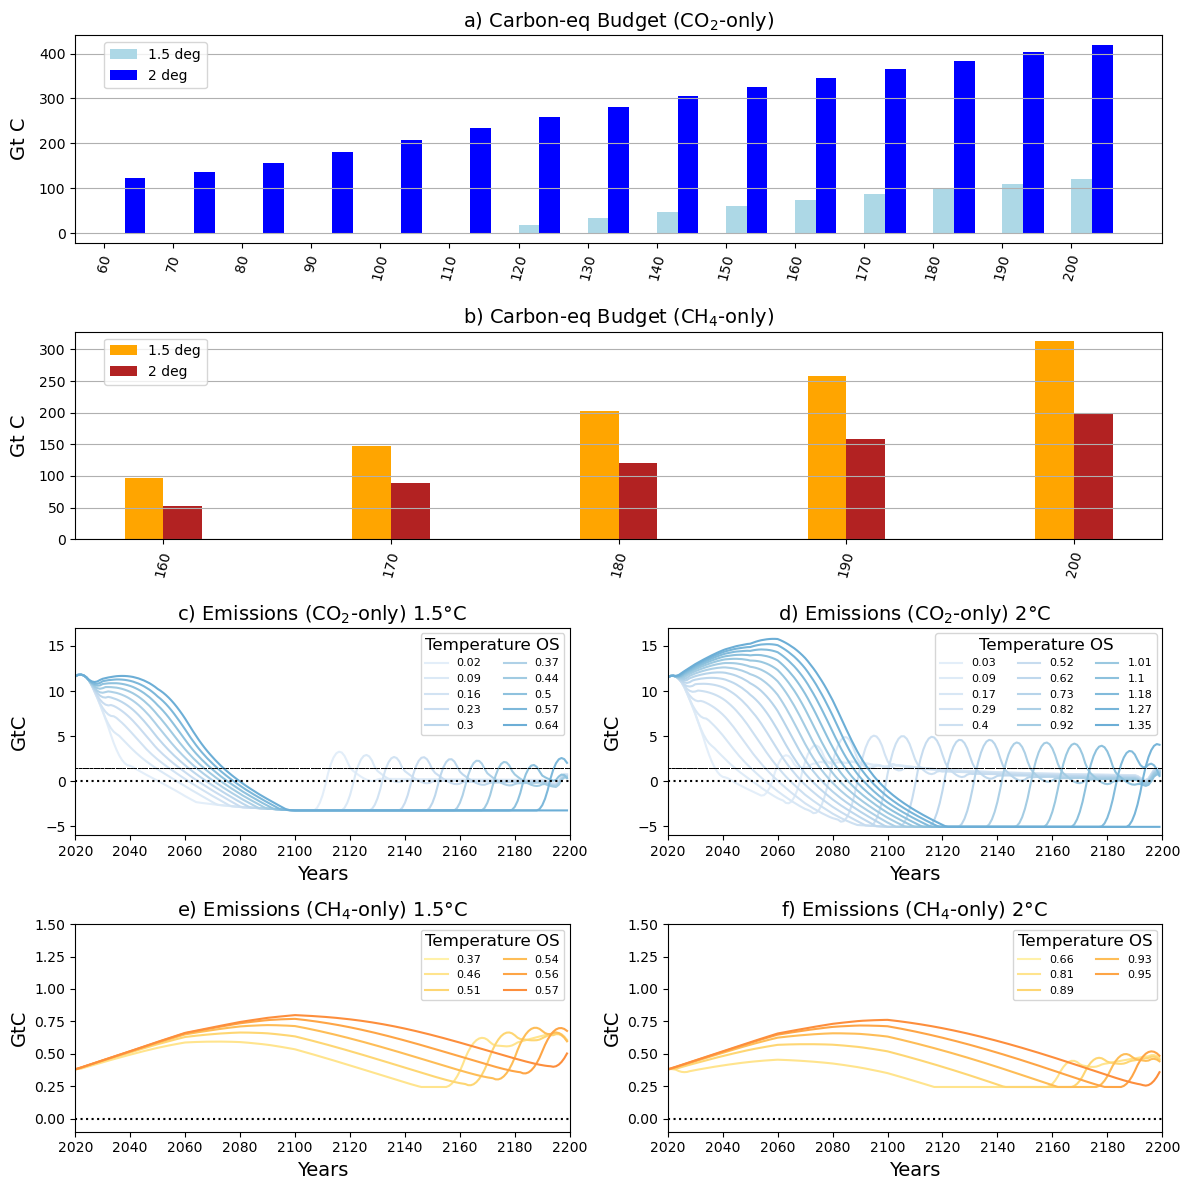

In [26]:
## -------------------- PLOT ---------------------##

# Plot configuration
width_inch = 12
height_inch = 12

model = "IPSL"
title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(4, 2)

# First Plot CO2 Budget
x = np.arange(len(targets[5:]))  # the label locations
ax = fig.add_subplot(gs[0, :])
ax.bar(x+5, df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)].CO2_OS, width=0.3, align='edge', label='1.5 deg', color="lightblue")
x1 = np.arange(len(targets))  # the label locations
ax.bar(x1 + 0.3, df_OS_co2_2[(df_OS_co2_2.DR == 4)].CO2_OS, width=0.3, align='edge', label='2 deg', color="blue")

ax.set_title('a) Carbon-eq Budget (CO$_2$-only)', size = 14)
ax.set_ylabel('Gt C', size = 14)
# ax.set_ylim(-100,OS_co2_20[-1]+50)
ax.set_xticks(x1, targets, rotation = 75)
ax.grid(axis = 'y')
ax.legend(loc='upper left',bbox_to_anchor=(0.02, 1))

# Second Plot CH4 Budget
x = np.arange(len(targets[10:]))  # the label locations
ax = fig.add_subplot(gs[1, :])
ax.bar(x - 0.17, df_OS_ch4_15[(df_OS_ch4_15.TARGET >= 156) & (df_OS_ch4_15.DR == 4)].CH4_OS, width=0.17, align='edge', label='1.5 deg', color="orange")
x1 = np.arange(len(targets[10:]))  # the label locations
ax.bar(x1, df_OS_ch4_2[(df_OS_ch4_2.TARGET >= 156) & (df_OS_ch4_2.DR == 4)].CH4_OS, width=0.17, align='edge', label='2 deg', color="firebrick")

ax.set_title('b) Carbon-eq Budget (CH$_4$-only)', size = 14)
ax.set_ylabel('Gt C', size = 14)
# ax.set_ylim(-100,OS_ch4_15[-1]+50)
ax.set_xticks(x, targets[10:], rotation = 75)
ax.grid(axis = 'y')
ax.legend(loc='upper left',bbox_to_anchor=(0.02, 1))

# Third Plot A CO2 Temp
ax = fig.add_subplot(gs[2, 0])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets[5:]))))
for scn in targets[5:]:
    c = next(color)
    data = df_co2_15[(df_co2_15.TARGET >= 106) & (df_co2_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    em = data["ANTCO2"]
    ax.plot(year[0:200],em[0:200], color = c)
    ax.axhline(1.5, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
    ax.set_ylim(1,3.5)
    ax.set_ylabel('°C', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlim(2020, 2200)
ax.set_ylim(-6, 17)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('c) Emissions (CO$_2$-only) 1.5°C', size = 14)
legend2 = df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="upper right",fontsize=8, ncol=2)


# Third Plot B CO2 Temp
ax = fig.add_subplot(gs[2, 1])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets))))
for scn in targets:
    c = next(color)
    data = df_co2_20[(df_co2_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    em = data["ANTCO2"]
    ax.plot(year[0:200],em[0:200], color = c)
    ax.axhline(1.5, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
    ax.set_ylim(1,3.5)
    ax.set_ylabel('°C', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlim(2020, 2200)
ax.set_ylim(-6, 17)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('d) Emissions (CO$_2$-only) 2°C', size = 14)
legend2 = df_OS_co2_2[(df_OS_co2_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="upper right",fontsize=8, ncol=3) #bbox_to_anchor=(0.50, 0.4),


# Fourth Plot A CH4 Temp
ax = fig.add_subplot(gs[3, 0])
color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[9:]:
    c = next(color)
    data = df_ch4_15[(df_ch4_15.TARGET >= 156) & (df_ch4_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    # em = (gwpstar(data.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
    em = data.ANTCH4*MttoGt
    ax.plot(year[0:200],em[0:200], color = c)
    ax.axhline(1.5, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlim(2020, 2200)
ax.set_ylim(-0.1,1.5)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('e) Emissions (CH$_4$-only) 1.5°C', size = 14)
legend2 = df_OS_ch4_15[(df_OS_ch4_15.TARGET >= 146) & (df_OS_ch4_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="upper right",fontsize=8, ncol=2)


# Fourth Plot B CH4 Temp
ax = fig.add_subplot(gs[3, 1])
color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[9:]:
    c = next(color)
    data = df_ch4_20[(df_ch4_20.TARGET >= 156) & (df_ch4_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    # em = (gwpstar(data.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
    em = data.ANTCH4*MttoGt
    ax.plot(year[0:200],em[0:200], color = c)
    ax.axhline(1.5, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlim(2020, 2200)
ax.set_ylim(-0.1,1.5)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('f) Emissions (CH$_4$-only) 2°C', size = 14)
legend2 = df_OS_ch4_2[(df_OS_ch4_2.TARGET >= 156) & (df_OS_ch4_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="upper right",fontsize=8, ncol=2)

fig.align_labels() 

# output file
title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)
# output_file = os.path.join(out_path,title.replace(' ','_')) + "_ANT.png"

# save the output file
# plt.savefig(output_file)

Legends outside figures

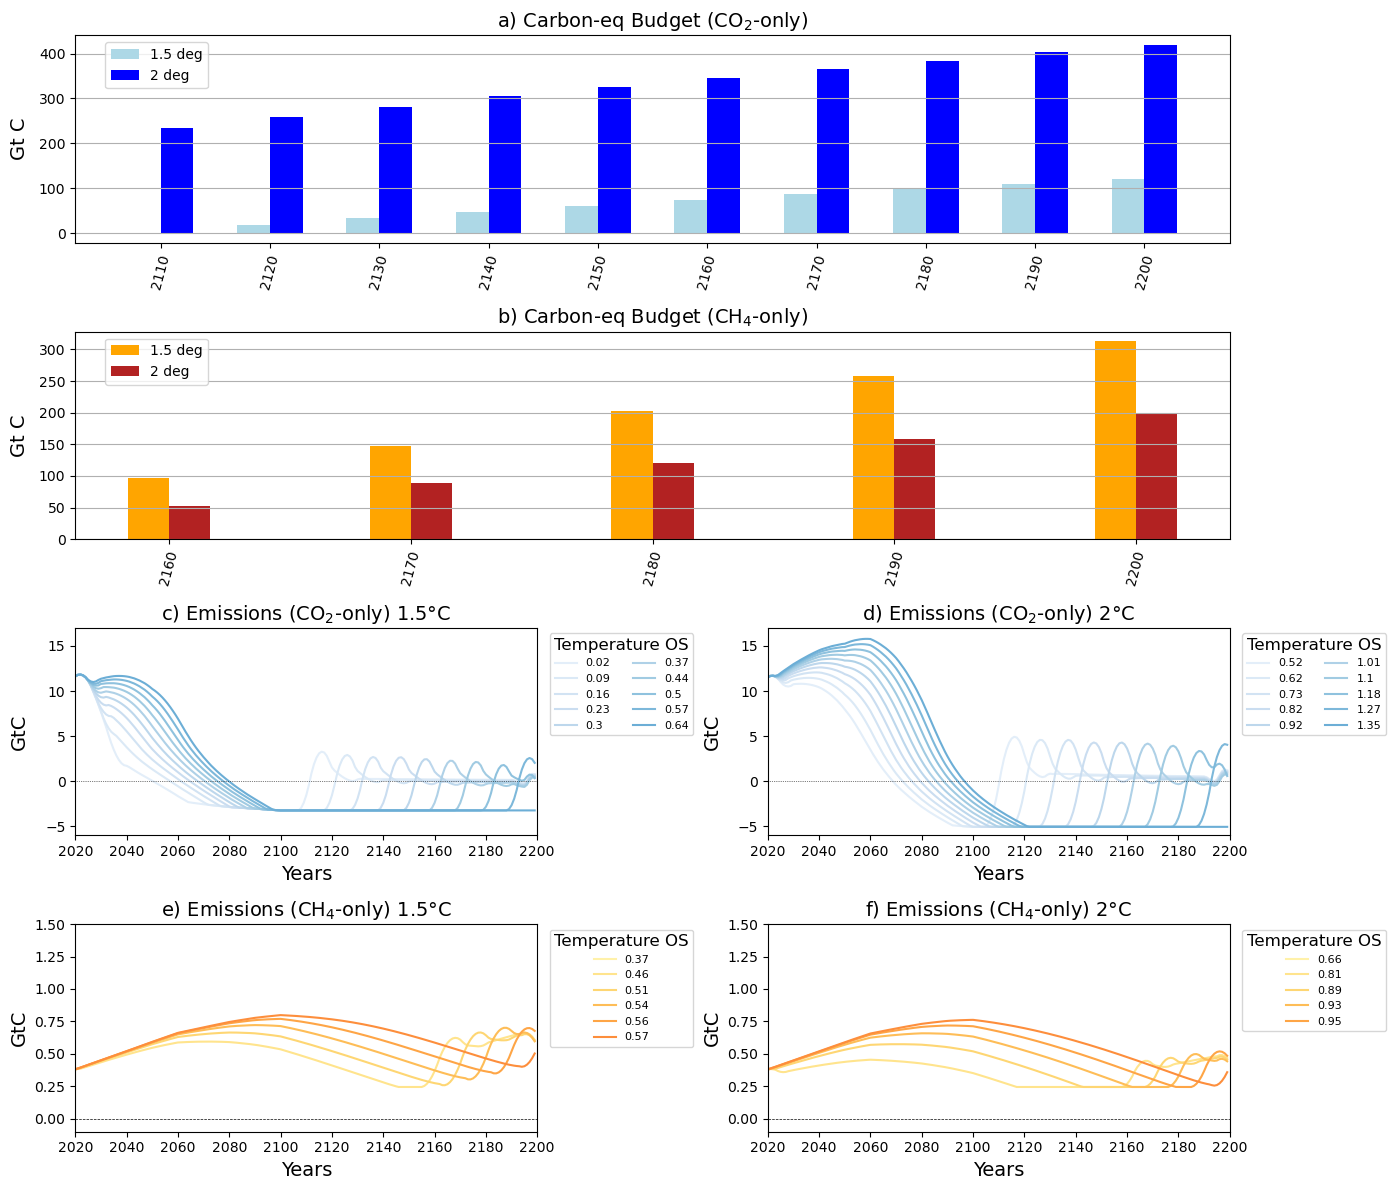

In [27]:
## -------------------- PLOT ---------------------##

# Plot configuration
width_inch = 14
height_inch = 12

model = "IPSL"
title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(4, 2)

# First Plot CO2 Budget
x = np.arange(len(targets_yrs[5:]))  # the label locations
ax = fig.add_subplot(gs[0, :])
ax.bar(x - 0.3, df_OS_co2_15[(df_OS_co2_15.TARGET >= 110) & (df_OS_co2_15.DR == 4)].CO2_OS, width=0.3, align='edge', label='1.5 deg', color="lightblue")
x1 = np.arange(len(targets_yrs[5:]))  # the label locations
ax.bar(x1, df_OS_co2_2[(df_OS_co2_2.TARGET >= 110) & (df_OS_co2_2.DR == 4)].CO2_OS, width=0.3, align='edge', label='2 deg', color="blue")

ax.set_title('a) Carbon-eq Budget (CO$_2$-only)', size = 14)
ax.set_ylabel('Gt C', size = 14)
# ax.set_ylim(-100,OS_co2_20[-1]+50)
ax.set_xticks(x1, targets_yrs[5:], rotation = 75)
ax.grid(axis = 'y')
ax.legend(loc='upper left',bbox_to_anchor=(0.02, 1))

# Second Plot CH4 Budget
x = np.arange(len(targets_yrs[10:]))  # the label locations
ax = fig.add_subplot(gs[1, :])
ax.bar(x - 0.17, df_OS_ch4_15[(df_OS_ch4_15.TARGET >= 160) & (df_OS_ch4_15.DR == 4)].CH4_OS, width=0.17, align='edge', label='1.5 deg', color="orange")
x1 = np.arange(len(targets_yrs[10:]))  # the label locations
ax.bar(x1, df_OS_ch4_2[(df_OS_ch4_2.TARGET >= 160) & (df_OS_ch4_2.DR == 4)].CH4_OS, width=0.17, align='edge', label='2 deg', color="firebrick")

ax.set_title('b) Carbon-eq Budget (CH$_4$-only)', size = 14)
ax.set_ylabel('Gt C', size = 14)
# ax.set_ylim(-100,OS_ch4_15[-1]+50)
ax.set_xticks(x, targets_yrs[10:], rotation = 75)
ax.grid(axis = 'y')
ax.legend(loc='upper left',bbox_to_anchor=(0.02, 1))

# Third Plot A CO2 Temp
ax = fig.add_subplot(gs[2, 0])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets[5:]))))
for scn in targets[5:]:
    c = next(color)
    data = df_co2_15[(df_co2_15.TARGET >= 110) & (df_co2_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    em = data["ANTCO2"]
    ax.plot(year[0:200],em[0:200], color = c)
    ax.set_ylim(1,3.5)
    ax.set_ylabel('°C', size = 14)
ax.axhline(0, linestyle='dotted', color="black",linewidth = 0.5,)
ax.set_xlim(2020, 2200)
ax.set_ylim(-6, 17)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('c) Emissions (CO$_2$-only) 1.5°C', size = 14)
legend2 = df_OS_co2_15[(df_OS_co2_15.TARGET >= 110) & (df_OS_co2_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,bbox_to_anchor=[1.35, 1],loc="upper right",fontsize=8, ncol=2)


# Third Plot B CO2 Temp
ax = fig.add_subplot(gs[2, 1])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets[5:]))))
for scn in targets[5:]:
    c = next(color)
    data = df_co2_20[(df_co2_15.TARGET >= 110) & (df_co2_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    em = data["ANTCO2"]
    ax.plot(year[0:200],em[0:200], color = c)
    ax.set_ylim(1,3.5)
    ax.set_ylabel('°C', size = 14)
ax.axhline(0, linestyle='dotted', color="black",linewidth = 0.5,)
ax.set_xlim(2020, 2200)
ax.set_ylim(-6, 17)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('d) Emissions (CO$_2$-only) 2°C', size = 14)
legend2 = df_OS_co2_2[(df_OS_co2_2.TARGET >= 110) &(df_OS_co2_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,bbox_to_anchor=[1.35, 1],loc="upper right",fontsize=8, ncol=2) #bbox_to_anchor=(0.50, 0.4),


# Fourth Plot A CH4 Temp
ax = fig.add_subplot(gs[3, 0])
color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[9:]:
    c = next(color)
    data = df_ch4_15[(df_ch4_15.TARGET >= 160) & (df_ch4_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    # em = (gwpstar(data.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
    em = data.ANTCH4*MttoGt
    ax.plot(year[0:200],em[0:200], color = c)
ax.axhline(0, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2020, 2200)
ax.set_ylim(-0.1,1.5)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('e) Emissions (CH$_4$-only) 1.5°C', size = 14)
legend2 = df_OS_ch4_15[(df_OS_ch4_15.TARGET >= 146) & (df_OS_ch4_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12, bbox_to_anchor=[1.35, 1],loc="upper right",fontsize=8, ncol=1)


# Fourth Plot B CH4 Temp
ax = fig.add_subplot(gs[3, 1])
color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[9:]:
    c = next(color)
    data = df_ch4_20[(df_ch4_20.TARGET >= 160) & (df_ch4_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    # em = (gwpstar(data.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
    em = data.ANTCH4*MttoGt
    ax.plot(year[0:200],em[0:200], color = c)
ax.axhline(0, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2020, 2200)
ax.set_ylim(-0.1,1.5)
ax.set_ylabel('GtC', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('f) Emissions (CH$_4$-only) 2°C', size = 14)
legend2 = df_OS_ch4_2[(df_OS_ch4_2.TARGET >= 160) & (df_OS_ch4_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12, bbox_to_anchor=[1.35, 1], loc="upper right",fontsize=8, ncol=1)

fig.align_labels() 

# output file
title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)
# output_file = os.path.join(out_path,title.replace(' ','_')) + "_ANT.png"

# save the output file
# plt.savefig(output_file)

### Temperature Pathways

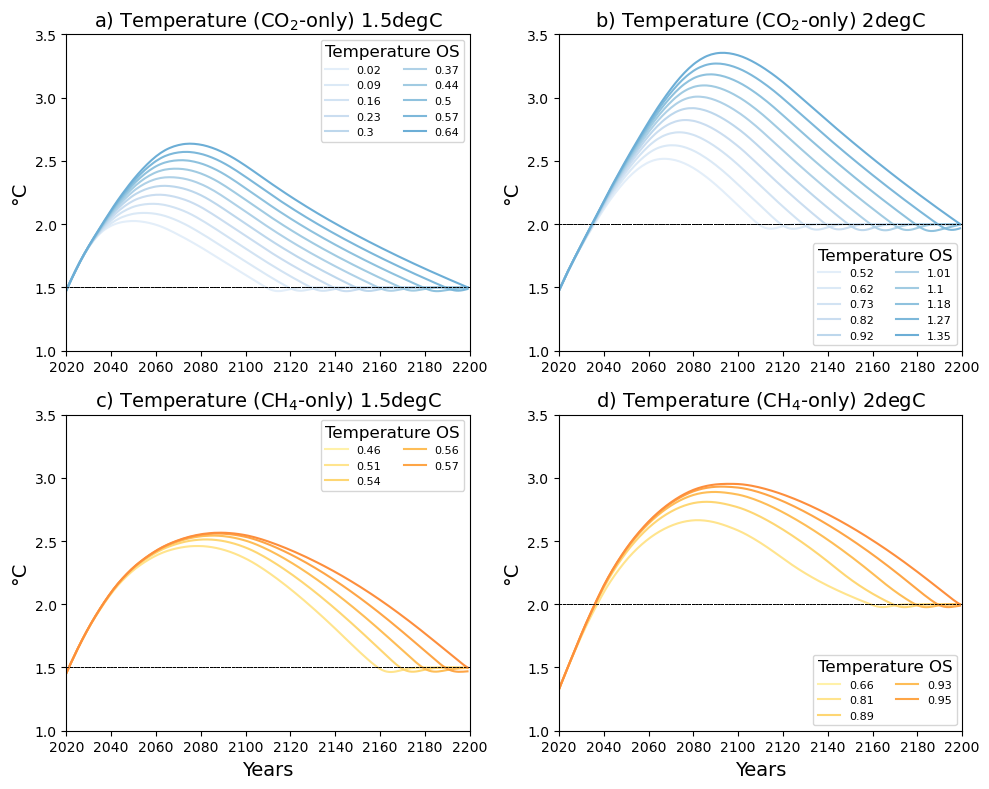

In [89]:
## -------------------- DATA ---------------------##
## -------------------- PLOT ---------------------##
#x = np.arange(len(columns_acc2))  # the label locations

# Plot configuration
width_inch = 10
height_inch = 8

#title = 'ACC2 CO$_2$ Emissions Simulations - Carbon Budget at {}'.format(targetOS GtC)

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ylabel = '°C'
xlabel = 'Years'

# First Plot C02_15
ax = fig.add_subplot(gs[0, 0])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets[5:]))))
for scn in targets[5:]:
    c = next(color)
    data = df_co2_15[(df_co2_15.TARGET >= 106) & (df_co2_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    temp = data.T2M
    ax.plot(year[0:200],temp[0:200], color = c)
    ax.axhline(1.5, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2020, 2200)
ax.set_ylim(1,3.5)
ax.set_title('a) Temperature (CO$_2$-only) 1.5degC', size = 14)
ax.set_ylabel(ylabel, size = 14)
# overshoot = tas_co2_15_acc2.columns
legend2 = df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="upper right",fontsize=8, ncol=2)

#ax.legend(loc='upper left')

# Second Plot C02_20 
ax = fig.add_subplot(gs[0, 1])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets[5:]))))
for scn in targets[5:]:
    c = next(color)
    data = df_co2_20[(df_co2_20.TARGET >= 106) & (df_co2_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    temp = data.T2M
    ax.plot(year[0:200],temp[0:200], color = c)
    ax.axhline(2, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2020, 2200)
ax.set_ylim(1,3.5)
ax.set_title('b) Temperature (CO$_2$-only) 2degC', size = 14)
ax.set_ylabel(ylabel, size = 14)
# overshoot = tas_co2_20_acc2.columns
legend2 = df_OS_co2_2[(df_OS_co2_2.TARGET >= 106) & (df_OS_co2_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="lower right",fontsize=8, ncol=2)


# Third Plot CH4_15 
ax = fig.add_subplot(gs[1, 0])
color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[9:]:
    c = next(color)
    data = df_ch4_15[(df_ch4_15.TARGET >= 156) & (df_ch4_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    # em = (gwpstar(data.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
    temp = data.T2M
    ax.plot(year[0:200],temp[0:200], color = c)
    ax.axhline(1.5, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2020, 2200)
ax.set_ylim(1,3.5)
ax.set_title('c) Temperature (CH$_4$-only) 1.5degC', size = 14)
ax.set_ylabel(ylabel, size = 14)
ax.set_xlabel(xlabel, size = 14)
# overshoot = tas_ch4_15_acc2.columns
legend2 = df_OS_ch4_15[(df_OS_ch4_15.TARGET >= 156) & (df_OS_ch4_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="upper right",fontsize=8, ncol=2)


# Fourth Plot CH4_20
ax = fig.add_subplot(gs[1, 1])
color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[9:]:
    c = next(color)
    data = df_ch4_20[(df_ch4_20.TARGET >= 156) & (df_ch4_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    temp = data.T2M
    ax.plot(year[0:200],temp[0:200], color = c)
    ax.axhline(2, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2020, 2200)
ax.set_ylim(1,3.5)
ax.set_title('d) Temperature (CH$_4$-only) 2degC', size = 14)
ax.set_ylabel(ylabel, size = 14)
ax.set_xlabel(xlabel, size = 14)
# overshoot = tas_ch4_20_acc2.columns
legend2 = df_OS_ch4_2[(df_OS_ch4_2.TARGET >= 156) & (df_OS_ch4_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="lower right",fontsize=8, ncol=2)

fig.align_labels()
title="ACC2 CO2+CH4 Emissions Simulations - Temperature Pathways - {} emulator".format(model)
# output file
output_file = os.path.join(out_path,title.replace(' ','_')) + ".png"

# save the output file
# plt.savefig(output_file)

### Scenarios before 2100

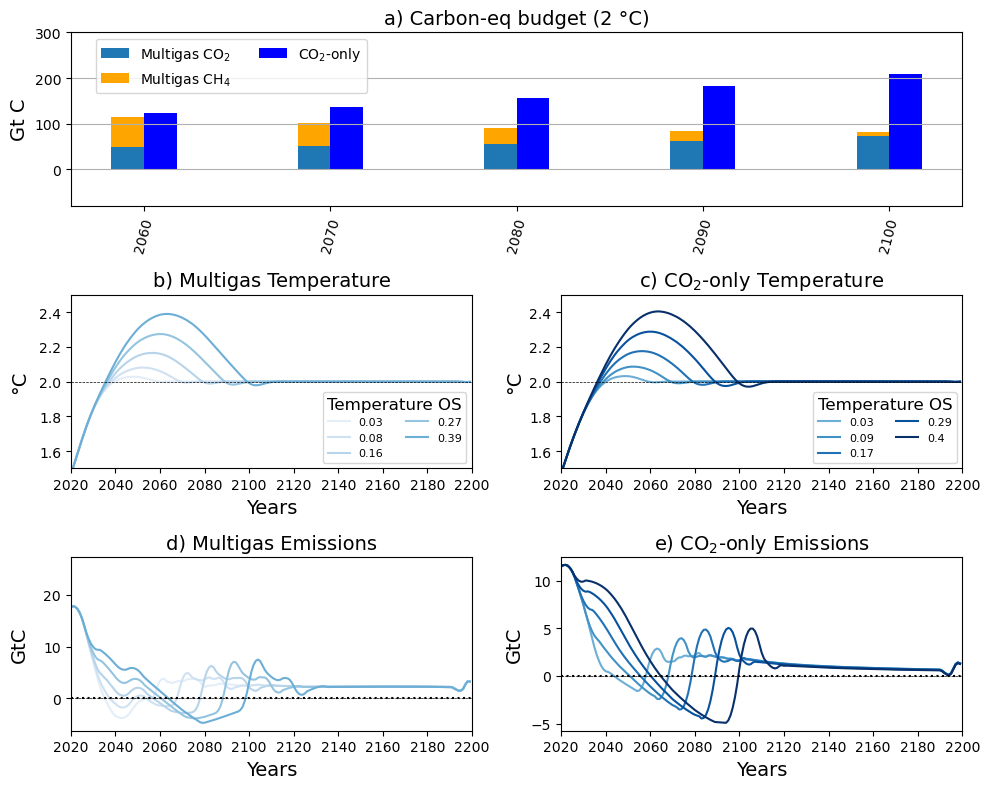

In [29]:
## -------------------- PLOT ---------------------##

# Plot configuration
width_inch = 10
height_inch = 8

model = "IPSL"
title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(3, 2)

# First Plot CO2 Budget
x = np.arange(len(targets_yrs[:5]))  # the label locations
ax = fig.add_subplot(gs[0, :])
ax.bar(x - width/2, df_OS_allghg_2[(df_OS_allghg_2.TARGET < 106) & (df_OS_allghg_2.DR == 4)].CO2_OS, width/2, align='edge', label='Multigas CO$_2$', color='tab:blue')
ax.bar(x - width/2, df_OS_allghg_2[(df_OS_allghg_2.TARGET < 106) & (df_OS_allghg_2.DR == 4)].CH4_OS, width/2, bottom = df_OS_allghg_2[(df_OS_allghg_2.TARGET < 106) & (df_OS_allghg_2.DR == 4)].CO2_OS, align='edge', label='Multigas CH$_4$', color = 'orange')
ax.bar(x, df_OS_co2_2[(df_OS_co2_2.TARGET < 106) & (df_OS_co2_2.DR == 4)].CO2_OS, width/2, align='edge', label='CO$_2$-only', color='blue')

ax.set_title('a) Carbon-eq budget (2 °C)', size = 14)
ax.set_ylabel('Gt C', size = 14)
ax.set_ylim(-80,300)
ax.set_xticks(x, targets_yrs[:5], rotation = 75)
ax.grid(axis = 'y')
ax.legend(loc='upper left',bbox_to_anchor=(0.02, 1), ncol = 2)

# Third Plot A CO2 Temp
ax = fig.add_subplot(gs[1, 0])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets_yrs[:5]))))
for scn in targets[:5]:
    c = next(color)
    data = df_all_20[(df_all_20.TARGET < 106) & (df_all_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    em = data["T2M"]
    ax.plot(year[0:200],em[0:200], color = c)
ax.axhline(2, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_ylim(1.5,2.5)
ax.set_xlim(2020, 2200)
ax.set_ylabel('°C', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlabel('Years', size = 14)
ax.set_title('b) Multigas Temperature', size = 14)
legend2 = df_OS_allghg_2[(df_OS_allghg_2.TARGET < 106) & (df_OS_allghg_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="lower right",fontsize=8, ncol=2)


# Third Plot B CO2 Temp
ax = fig.add_subplot(gs[1, 1])
color = iter(cm.Blues_r(np.linspace(0.5, 0, len(targets_yrs[:5]))))
for scn in targets[:5]:
    c = next(color)
    data = df_co2_20[(df_co2_20.TARGET < 106) & (df_co2_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    em = data["T2M"]
    ax.plot(year[0:200],em[0:200], color = c)
ax.axhline(2, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_ylim(1.5,2.5)
ax.set_xlim(2020, 2200)
ax.set_ylabel('°C', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlabel('Years', size = 14)
ax.set_title('c) CO$_2$-only Temperature', size = 14)
legend2 = df_OS_co2_2[(df_OS_co2_2.TARGET < 106) &(df_OS_co2_2.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="lower right",fontsize=8, ncol=2) #bbox_to_anchor=(0.50, 0.4),


# Plot Multigas emissions
ax = fig.add_subplot(gs[2, 0])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets_yrs[:5]))))
for scn in targets[:5]:
    c = next(color)
    data = df_all_20[(df_all_20.TARGET < 106) & (df_all_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    ghg = data["ANTCO2"] + gwpstar(data.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC + data['ANTN2O']*265*NtoN2O*MttoGt*CO2toC
    em = ghg
    ax.plot(year[0:200],em[0:200], color = c)
ax.axhline(0, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
# ax.set_ylim(1.5,2.5)
ax.set_xlim(2020, 2200)
ax.set_ylabel('GtC', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlabel('Years', size = 14)
ax.set_title('d) Multigas Emissions', size = 14)


# Plot CO2-only emissions
ax = fig.add_subplot(gs[2, 1])
color = iter(cm.Blues_r(np.linspace(0.5, 0, len(targets_yrs[:5]))))
for scn in targets[:5]:
    c = next(color)
    data = df_co2_20[(df_co2_20.TARGET < 106) & (df_co2_20.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"]
    em = data["ANTCO2"]
    ax.plot(year[0:200],em[0:200], color = c)
ax.axhline(0, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
# ax.set_ylim(1.5,2.5)
ax.set_xlim(2020, 2200)
ax.set_ylabel('GtC', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlabel('Years', size = 14)
ax.set_title('e) CO$_2$-only Emissions', size = 14)

fig.align_labels() 

# output file
title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)
# output_file = os.path.join(out_path,title.replace(' ','_')) + "_ANT.png"

# save the output file
# plt.savefig(output_file)

## Carbon Budgets as Tokarska (2019)


In [30]:
df_OS_co2_2 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'GHG_OS', 'CO2_OS', 'CH4_OS'])
df_OS_co2_2.TARGET = targets
df_OS_co2_2=df_OS_co2_2.reindex(df_OS_co2_2.index.repeat(len(drates)))


dfs = []
for scn in targets:

    # Assign DR values for every target
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_co2_20[df_co2_20["TARGET"] == scn].copy()

    overshoot = []; osco2 = []; osch4 = []; t2m_os = []; cbbefore = []; cbafter = []; over_tokarska19 = []; over_tokarska19ghg = []
    tcre_pos = []; tcre_neg = []; tcreplus_pos = []; tcreplus_neg = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative N2O emissions
        data1['CUMN2O'] = np.cumsum(data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']
        # Total GHG
        data1['GHG'] = (data1.ANTCO2) + (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC) + (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)

        ## CARBON BUDGET calculation (Tokarska, 2019)
        maxt2m = (data1["T2M"]).idxmax()
        before = (data1["T2M"].loc[:maxt2m] <= 2).iloc[::-1].idxmax()       # Last data before passing 2 °C
        after = (data1["T2M"].loc[maxt2m:] > 2).iloc[::-1].idxmax()+1       # First data after returning  to 2 °C
        maxcumem = (data1['CUMCO2'].loc[before:after].idxmax())
        cbbefore.append(data1['CUMCO2'].loc[before])
        cbafter.append(data1['CUMCO2'].loc[after])
        over_tokarska19.append(data1['CUMCO2'].loc[maxcumem] - data1['CUMCO2'].loc[before])


        # Threshold exceeding CARBON BUDGET
        over = (data1['CUMGHG'][after] - data1['CUMGHG'][data1['CUMGHG'].index[0]+20])
        overco2 = (data1['CUMCO2'][after] - data1['CUMCO2'][data1['CUMCO2'].index[0]+20])
        overch4 = (data1['CUMCH4'][after] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])
        # Temperature overshoot
        t2m_over = (data1['T2M'][maxt2m] - 2)
        # Populate the list
        overshoot.append(over)
        osco2.append(overco2)
        osch4.append(overch4)
        t2m_os.append(t2m_over)

        ## TCRE calculation
        # Peak cumghg
        maximum = (data1['GHG']<0).idxmax()
        # Lowest Peak cumghg
        minimum = data1[data1['YEAR'] == (2000 + scn -1)].index[0]
        # TCRE+ and TCRE-
        tplus_pos = (data1['T2M'][maximum]/data1['CUMGHG'][maximum])*1000
        tplus_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMGHG'][minimum] - data1['CUMGHG'][maximum]))*1000
        t_pos = (data1['T2M'][maximum]/data1['CUMCO2'][maximum])*1000
        t_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMCO2'][minimum] - data1['CUMCO2'][maximum]))*1000
        # Populate the list
        tcre_pos.append(t_pos)
        tcre_neg.append(t_neg)
        tcreplus_pos.append(tplus_pos)
        tcreplus_neg.append(tplus_neg)
            
        dfs.append(data1)

    # Populate the dataframe with overshoot amounts
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'GHG_OS'] = np.array(overshoot)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CO2_OS'] = np.array(osco2)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CBbefore_tok19'] = np.array(cbbefore)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CBafter_tok19'] = np.array(cbafter)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'OS_co2_tok19'] = np.array(over_tokarska19)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCRE+'] = np.array(tcre_pos)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCRE-'] = np.array(tcre_neg)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCREplus+'] = np.array(tcreplus_pos)
    df_OS_co2_2.loc[df_OS_co2_2['TARGET'] == scn, 'TCREplus-'] = np.array(tcreplus_neg)
df_tcre_co2_2 = pd.concat(dfs, ignore_index=True)


df_OS_co2_2[df_OS_co2_2['TARGET'] == 80]#.shape[0]

,TARGET,DR,T2M_OS,GHG_OS,CO2_OS,CH4_OS,CBbefore_tok19,CBafter_tok19,OS_co2_tok19,TCRE+,TCRE-,TCREplus+,TCREplus-
2,80,2,0.1139,131.601565,157.4496,-96.618935,342.1721,356.9096,31.8647,5.653584,6.702050,3.416915,6.030273
2,80,3,0.1442,130.419365,156.2674,-96.618935,346.6435,355.7274,40.4129,5.540120,4.601040,3.389148,4.238684
2,80,4,0.1749,128.796865,154.6449,-96.618935,350.2893,354.1049,50.3142,5.425783,3.727882,3.361054,3.490975
2,80,5,0.2047,127.059565,152.9076,-96.618935,359.3287,352.3676,54.7075,5.317947,3.267554,3.332616,3.082134
2,80,6,0.2284,126.079965,151.928,-96.618935,359.3057,351.3880,65.4349,5.235363,3.043718,3.308879,2.873914
2,80,7,0.2462,124.874665,150.7227,-96.618935,365.5439,350.1827,67.2816,5.173299,2.886999,3.288808,2.721447


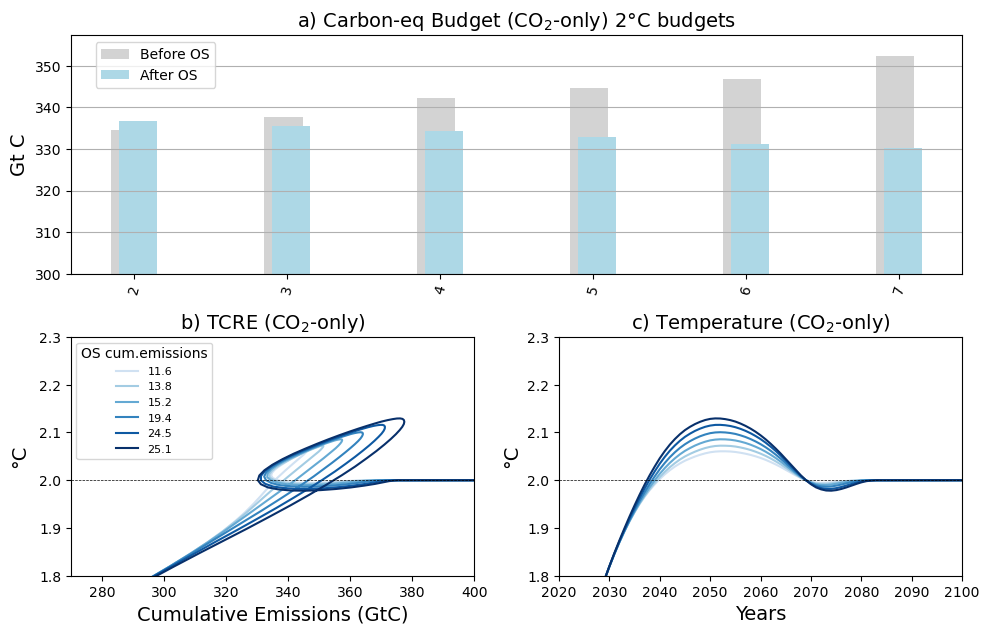

In [157]:
## -------------------- PLOT ---------------------##

# Plot configuration
width_inch = 10
height_inch = 12

model = "IPSL"
title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(4, 2)

# First Plot CO2 Budget
scn = df_OS_co2_2[(df_OS_co2_2.TARGET == 70)].CBbefore_tok19.shape[0]
x = np.arange(df_OS_co2_2[(df_OS_co2_2.TARGET == 70)].CBbefore_tok19.shape[0])  # the label locations
ax = fig.add_subplot(gs[0, :])
ax.bar(x - 0.3/2, df_OS_co2_2[(df_OS_co2_2.TARGET == 70)].CBbefore_tok19, width=0.25, align='edge', label='Before OS', color="lightgrey")
ax.bar(x - 0.2/2, df_OS_co2_2[(df_OS_co2_2.TARGET == 70)].CBafter_tok19, width=0.25, align='edge', label='After OS', color="lightblue")

ax.set_title('a) Carbon-eq Budget (CO$_2$-only) 2°C budgets', size = 14)
ax.set_ylabel('Gt C', size = 14)
ax.set_ylim(300,df_OS_co2_2[(df_OS_co2_2.TARGET == 70)].CBbefore_tok19.max()+5)
ax.set_xticks(x, drates, rotation = 75)
ax.grid(axis = 'y')
ax.legend(loc='upper left',bbox_to_anchor=(0.02, 1))


# Third Plot B CO2 Temp
ax = fig.add_subplot(gs[1, 0])
color = iter(cm.Blues_r(np.linspace(0.8, 0, scn)))
for dr in drates:
    c = next(color)
    data = df_co2_20[(df_co2_20.TARGET == 70)]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    t2m = data[data['DR'] == dr]["T2M"]
    ax.plot(em[0:200],t2m[0:200], color = c)
ax.axhline(2, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_ylim(1.8,2.3)
ax.set_ylabel('°C', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlim(270, 400)
ax.set_ylabel('°C', size = 14)
ax.set_xlabel('Cumulative Emissions (GtC)', size = 14)
ax.set_title('b) TCRE (CO$_2$-only)', size = 14)
legend2 = df_OS_co2_2[(df_OS_co2_2.TARGET == 70)].OS_co2_tok19.astype(float).round(1)
ax.legend(legend2, title = "OS cum.emissions", title_fontsize = 10,loc="upper left",fontsize=8, ncol=1) #bbox_to_anchor=(0.50, 0.4),

ax = fig.add_subplot(gs[1, 1])
color = iter(cm.Blues_r(np.linspace(0.8, 0, scn)))
for dr in drates:
    c = next(color)
    data = df_co2_20[(df_co2_20.TARGET == 70)]
    year = data[data['DR'] == dr]["YEAR"]
    em = data[data['DR'] == dr]["ANTCO2"].cumsum()
    t2m = data[data['DR'] == dr]["T2M"]
    ax.plot(year[0:200],t2m[0:200], color = c)
ax.axhline(2, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_ylim(1.8,2.3)
ax.set_ylabel('°C', size = 14)
plt.axhline(0, linestyle='dotted', color="black")
ax.set_xlim(2020, 2100)
ax.set_ylabel('°C', size = 14)
ax.set_xlabel('Years', size = 14)
ax.set_title('c) Temperature (CO$_2$-only)', size = 14)
# legend2 = df_OS_co2_2[(df_OS_co2_2.TARGET == 70)].T2M_OS.astype(float).round(2)
# ax.legend(legend2, title = "Temperature OS", title_fontsize = 12,loc="upper left",fontsize=8, ncol=1) #bbox_to_anchor=(0.50, 0.4),

fig.align_labels() 

# output file
# title = 'ACC2 CO2+CH4 Emissions Simulations - Carbon Budget - {} emulator'.format(model)
# output_file = os.path.join(out_path,title.replace(' ','_')) + "_ANT.png"

# save the output file
# plt.savefig(output_file)

Text(0, 0.5, 'GtC')

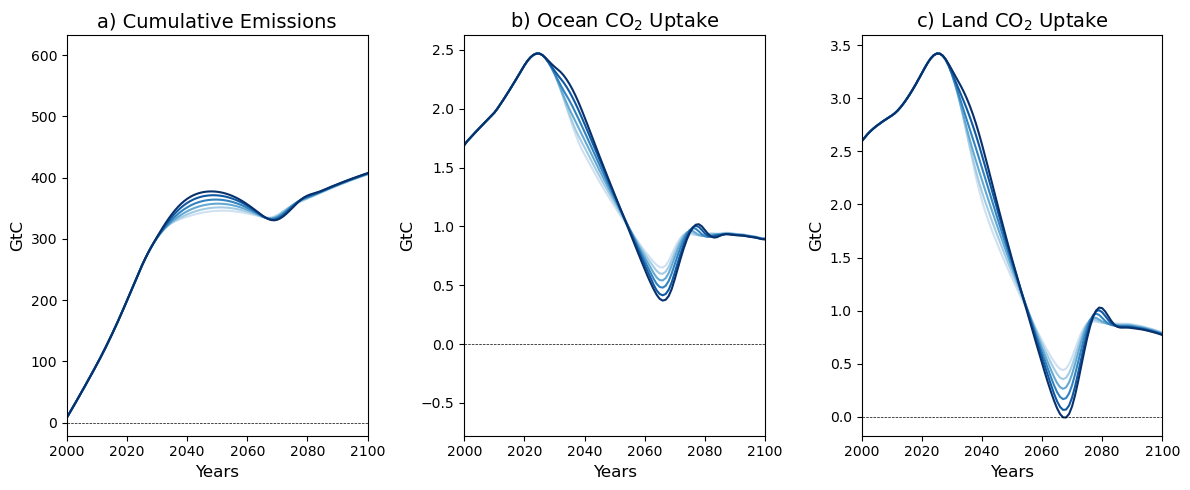

In [87]:
width_inch = 12
height_inch = 5
fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)

xlabel = 'Years'

data = df_co2_20[(df_co2_20.TARGET == 70)]

# First Plot

ax = fig.add_subplot(131)
color = iter(cm.Blues_r(np.linspace(0.8, 0, 6)))
for dr in drates:
    c = next(color)
    to_plot = data[data['DR'] == dr]
    ax.plot(to_plot.YEAR,to_plot.ANTCO2.cumsum(), color=c, linewidth=1.5)
ax.axhline(0, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2000, 2100)
ax.set_title('a) Cumulative Emissions', size = 14)
ax.set_xlabel(xlabel, size = 12)
ax.set_ylabel("GtC", size = 12)
# ax.legend(title = "simulations", title_fontsize = 12,bbox_to_anchor=(0.9, 0.9),fontsize=8)

# Second Plot

ax = fig.add_subplot(132)
color = iter(cm.Blues_r(np.linspace(0.8, 0, 6)))
for dr in drates:
    c = next(color)
    to_plot = data[data['DR'] == dr]
    ax.plot(to_plot.YEAR,to_plot.OCNCO2UP, color=c, linewidth=1.5)
ax.axhline(0, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2000, 2100)
ax.set_title('b) Ocean CO$_2$ Uptake', size = 14)
ax.set_xlabel(xlabel, size = 12)
ax.set_ylabel("GtC", size = 12)

# Third Plot

ax = fig.add_subplot(133)
color = iter(cm.Blues_r(np.linspace(0.8, 0, 6)))
for dr in drates:
    c = next(color)
    to_plot = data[data['DR'] == dr]
    ax.plot(to_plot.YEAR[:200],np.float64(to_plot.LNDCO2UP[:200]), color=c, linewidth=1.5)
ax.axhline(0, linestyle = "dashed", color = "black", linewidth = 0.5, label='_nolegend_')
ax.set_xlim(2000, 2100)
ax.set_title('c) Land CO$_2$ Uptake', size = 14)
ax.set_xlabel(xlabel, size = 12)
ax.set_ylabel("GtC", size = 12)




## TCRE and overshoot amount

### CO2 and CH4 TCRE plot

2 plots

4 plots

In [273]:
print(df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)]['TCREplus+'].mean())
print(df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)]['TCREplus-'].mean())

print(df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)]['TCRE+'].mean())
print(df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)]['TCRE-'].mean())


3.1636939745850237
4.898139328882871
4.729103393017278
3.3346668772641848


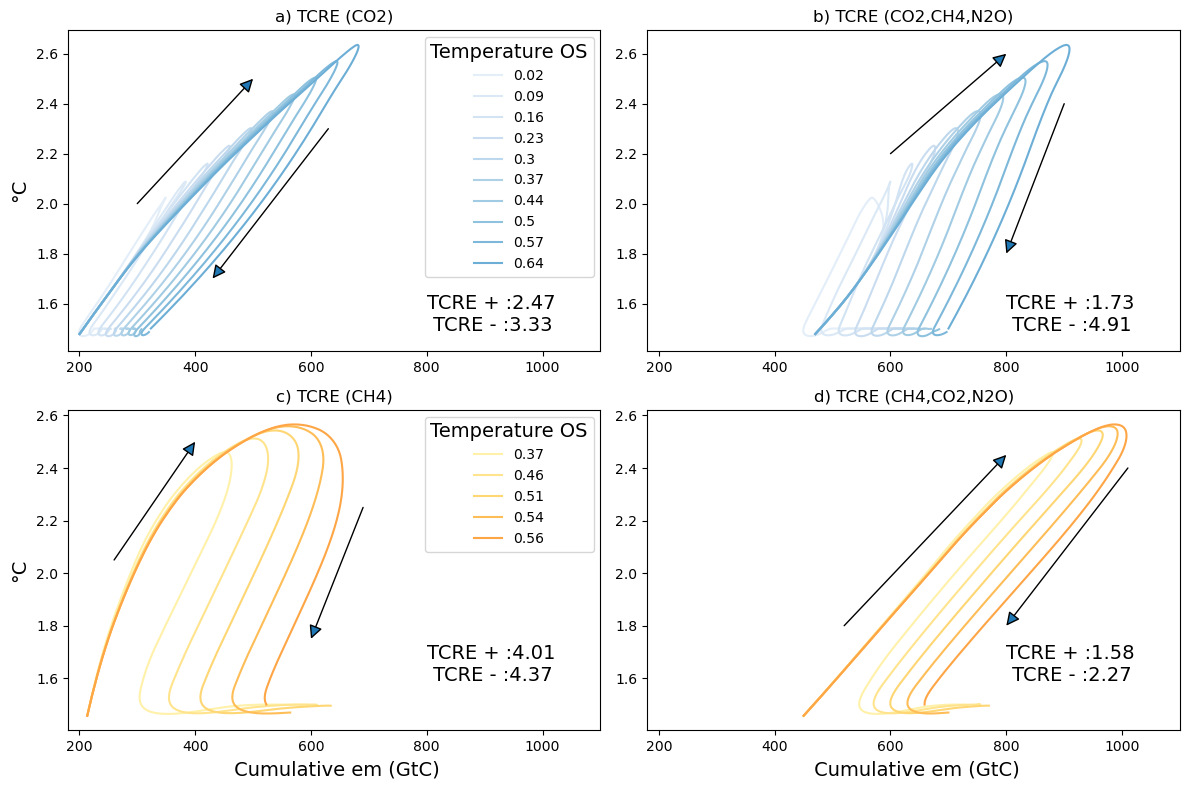

In [88]:
## -------------------- PLOT ---------------------##
title = 'ACC2 1.5 degC target CO2 & CH4 - TCRE, IPSL emulation'

# Plot configuration
width_inch = 12
height_inch = 8

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

# Plot Ratio N/P
# xlabel = 'Overshoot Amount'
# ylabel = 'Ratio'
# xlabelpad = 5
# ylabelpad = 5
# ax = fig.add_subplot(gs[0, 0])
# ax.plot(OS_ch4_15[7:],ratio_ch4_15[7:], marker='o')
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
# ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
# ax.set_title("Ratio N/P emissions")

# Plot TCRE CH4
xlabel = 'Cumulative em (GtC)'
ylabel = 'Temperature (°C)'
xlabelpad = 5
ylabelpad = 5

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)

xlabelpad = 5
ylabelpad = 5


# Plot TCRE CO2
xlabel = ' Cumulative em (GtC)'
ylabel = '°C'
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 0])
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets[5:]))))
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)

for scn in targets[5:]:
    c = next(color)
    data = df_tcre_co2_15[(df_tcre_co2_15.TARGET >= 106) & (df_co2_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"][20:200]
    em = data["CUMCO2"][20:200]
    temp = data['T2M'][20:200]
    ax.plot(em, temp,label=overshoot, color=c)
ax.annotate("", xytext=(300, 2), xy=(500,2.5),  xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(630, 2.3), xy=(430,1.7), xycoords = 'data', arrowprops=prop)
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_xlim(180,1100)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
ax.text(800, 1.5,'TCRE + :2.47\n TCRE - :3.33', wrap = True, size = 14)
ax.set_title("a) TCRE (CO2)")
legend = df_OS_co2_15[(df_OS_co2_15.TARGET >= 106) & (df_OS_co2_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend, loc='upper right',title = "Temperature OS", title_fontsize = 14, fontsize=10)

# Plot TCRE CO2+CH4+N2O
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 1])

color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(targets[5:]))))
for scn in targets[5:]:
    c = next(color)
    data = df_tcre_co2_15[(df_tcre_co2_15.TARGET >= 106) & (df_co2_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"][20:200]
    em = data["CUMGHG"][20:200]
    temp = data['T2M'][20:200]
    ax.plot(em, temp,label=overshoot, color=c)
ax.annotate("", xytext=(600, 2.2), xy=(800,2.6), xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(900, 2.4), xy=(800,1.8), xycoords = 'data', arrowprops=prop)
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_xlim(180,1100)
ax.text(800, 1.5,'TCRE + :1.73\n TCRE - :4.91', wrap = True, size = 14)
ax.set_title("b) TCRE (CO2,CH4,N2O)")


ax = fig.add_subplot(gs[1, 0])

color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[10:]:
    c = next(color)
    data = df_tcre_ch4_15[(df_tcre_ch4_15.TARGET >= 156) & (df_tcre_ch4_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"][20:200]
    em = data["CUMCH4"][20:200]
    temp = data['T2M'][20:200]
    ax.plot(em, temp,label=overshoot, color=c)
ax.annotate("", xytext=(260, 2.05), xy=(400, 2.5), xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(690, 2.25), xy=(600, 1.75), xycoords = 'data', arrowprops=prop)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
ax.set_xlim(180,1100)
ax.text(800, 1.6,'TCRE + :4.01\n TCRE - :4.37', wrap = True,  size = 14)
ax.set_title("c) TCRE (CH4)")
legend2 = df_OS_ch4_15[(df_OS_ch4_15.TARGET >= 146) & (df_OS_ch4_15.DR == 4)].T2M_OS.astype(float).round(2)
ax.legend(legend2, loc='upper right',title = "Temperature OS", title_fontsize = 14, fontsize=10)

# Plot TCRE CH4+CO2+N2O
ax = fig.add_subplot(gs[1, 1])

color = iter(cm.YlOrRd_r(np.linspace(0.9, 0.5, len(targets[9:]))))
for scn in targets[10:]:
    c = next(color)
    data = df_tcre_ch4_15[(df_tcre_ch4_15.TARGET >= 156) & (df_tcre_ch4_15.DR == 4)]
    data = data[data["TARGET"] == scn]
    year = data["YEAR"][20:200]
    em = data["CUMGHG"][20:200]
    temp = data['T2M'][20:200]
    ax.plot(em, temp,label=overshoot, color=c)
ax.annotate("", xytext=(520, 1.8), xy=(800,2.45), xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(1010, 2.4), xy=(800,1.8), xycoords = 'data', arrowprops=prop)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_xlim(180,1100)
ax.text(800, 1.6,'TCRE + :1.58\n TCRE - :2.27', wrap = True, size = 14)
ax.set_title("d) TCRE (CH4,CO2,N2O)")


# output file
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path,title.replace(' ','_')) + "OS_em_4plots.png"

# save the output file
# plt.savefig(output_file)

TCRE for single CO2 and CH4 simulations displayed in the following figure as the difference among runsm so that to show the net CH4 effect

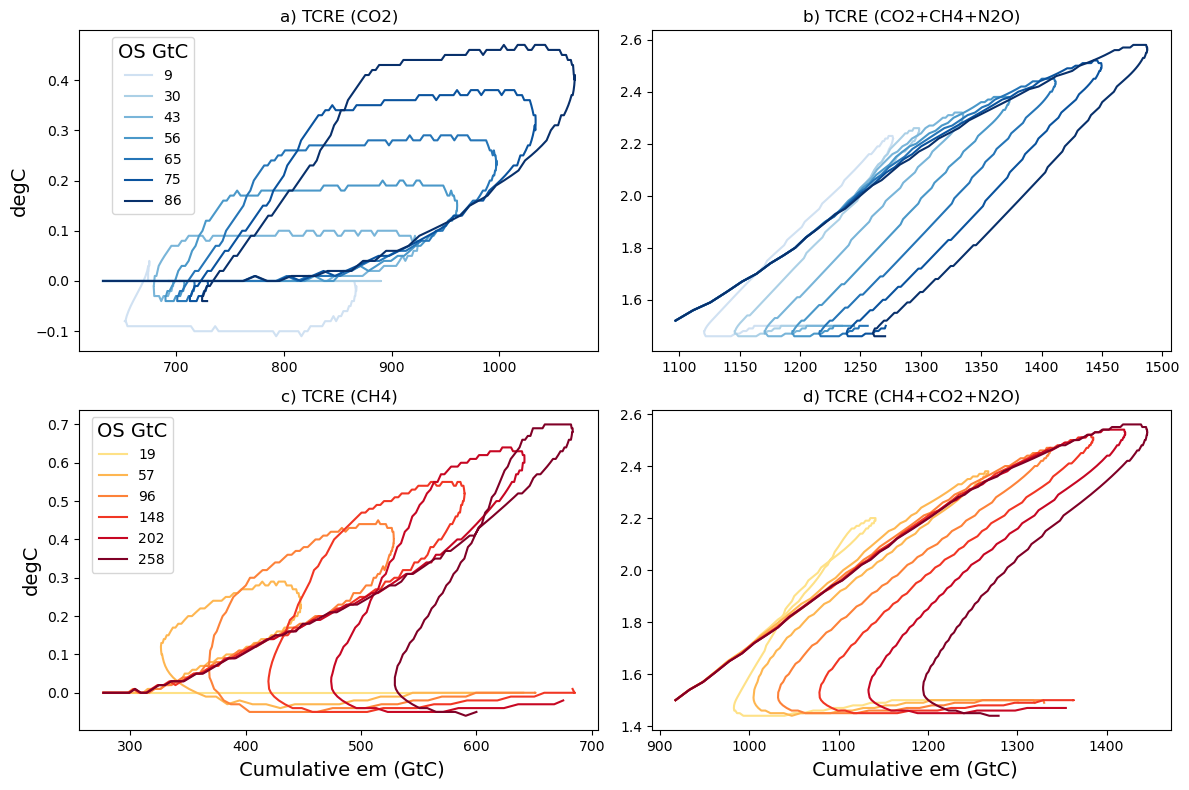

In [76]:
## -------------------- PLOT ---------------------##
title = 'ACC2 1.5 degC target CO2 & CH4 - TCRE, IPSL emulation'

# Plot configuration
width_inch = 12
height_inch = 8

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

# Plot TCRE CH4
xlabel = 'Cumulative em (GtC)'
ylabel = 'Temperature (degC)'
xlabelpad = 5
ylabelpad = 5

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)

xlabelpad = 5
ylabelpad = 5


# Plot TCRE CO2

tas_co2_15_acc2_diff = tas_co2_15_acc2.subtract(tas_co2_15_acc2[2140], axis = 'rows')

xlabel = ' Cumulative em (GtC)'
ylabel = 'degC'
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 0])
color = iter(cm.Blues_r(np.linspace(0.8, 0, len(tas_co2_15_acc2.T))))

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)

overshoot = np.int64(OS_co2_15[:])
for x, item in enumerate(tas_co2_15_acc2.columns):
    c = next(color)
    ax.plot(co2cum_15_acc2.iloc[270:450,x], tas_co2_15_acc2_diff.iloc[270:450,x],label=overshoot, color=c)
# ax.annotate("", xytext=(700, 1.9), xy=(900,2.4),  xycoords = 'data', arrowprops=prop)
# ax.annotate("", xytext=(1050, 2.3), xy=(850,1.7), xycoords = 'data', arrowprops=prop)
ax.legend(overshoot, loc='upper left',title = "OS GtC", title_fontsize = 14, bbox_to_anchor=(0.05, 1), fontsize=10)
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
# ax.text(950, 1.5,'TCRE + :2.47\n TCRE - :3.33', wrap = True, size = 14)
ax.set_title("a) TCRE (CO2)")

# Plot TCRE CO2+CH4+N2O
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 1])
color = iter(cm.Blues_r(np.linspace(0.8, 0, len(tas_co2_15_acc2.T))))

overshoot = np.int64(OS_co2_15[:])
for x, item in enumerate(tas_co2_15_acc2.columns):
    c = next(color)
    ax.plot(co2cum_15_acc2_plus.iloc[270:450,x], tas_co2_15_acc2.iloc[270:450,x],label=overshoot, color=c)
# ax.annotate("", xytext=(1150, 1.8), xy=(1350,2.5),  xycoords = 'data', arrowprops=prop)
# ax.annotate("", xytext=(1450, 2.2), xy=(1350,1.65), xycoords = 'data', arrowprops=prop)
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
# ax.text(1380, 1.5,'TCRE + :1.73\n TCRE - :4.91', wrap = True, size = 14)
ax.set_title("b) TCRE (CO2+CH4+N2O)")


tas_ch4_15_acc2_diff = tas_ch4_15_acc2.subtract(tas_ch4_15_acc2[2140], axis = 'rows')

ax = fig.add_subplot(gs[1, 0])

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)

color = iter(cm.YlOrRd_r(np.linspace(0.8, 0, len(tas_ch4_15_acc2.T))))
overshoot = np.int64(OS_ch4_15[:])
for x, item in enumerate(tas_ch4_15_acc2.columns):
    c = next(color)
    ax.plot(gwpch4cum_15_acc2.iloc[270:450,x], tas_ch4_15_acc2_diff.iloc[270:450,x],label=overshoot, color=c)
# ax.annotate("", xytext=(320, 2.05), xy=(440, 2.5), xycoords = 'data', arrowprops=prop)
# ax.annotate("", xytext=(690, 2.25), xy=(600, 1.75), xycoords = 'data', arrowprops=prop)
ax.legend(overshoot, loc='upper left',title = "OS GtC", title_fontsize = 14, bbox_to_anchor=(0.01, 1), fontsize=10)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
# ax.text(570, 1.6,'TCRE + :4.01\n TCRE - :1.39', wrap = True,  size = 14)
ax.set_title("c) TCRE (CH4)")

# Plot TCRE CH4+CO2+N2O
ax = fig.add_subplot(gs[1, 1])

color = iter(cm.YlOrRd_r(np.linspace(0.8, 0, len(tas_ch4_15_acc2.T))))
for x, item in enumerate(tas_ch4_15_acc2.columns):
    c = next(color)
    ax.plot(gwpch4cum_15_acc2_plus.iloc[270:450,x], tas_ch4_15_acc2.iloc[270:450,x],label=overshoot, color=c)
# ax.annotate("", xytext=(1000, 1.85), xy=(1200,2.4), xycoords = 'data', arrowprops=prop)
# ax.annotate("", xytext=(1400, 2.2), xy=(1280,1.8), xycoords = 'data', arrowprops=prop)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
# ax.text(1300, 1.6,'TCRE + :1.58\n TCRE - :2.41', wrap = True, size = 14)
ax.set_title("d) TCRE (CH4+CO2+N2O)")

# output file
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path,title.replace(' ','_')) + "OS_em_4plots.png"

# save the output file
# plt.savefig(output_file)

# GWP conversion in ACC2

In [77]:
simulations_ch4 = [2090, 2100, 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2200, 2210, 2220, 2230, 2240]

## -- TEMPERATURE
folder = "/CarbonBudget_BETA&Q10_COU_new_IPSL_gwp/CH4_15/"
file = "T2M_" + model + ".csv"
df_acc2_tas_ch4_15=pd.read_csv(os.path.join(data_path+folder+file), header=0)
df_acc2_tas_ch4_15.columns = [2240, 2230, 2220, 2210, 2200, 2190, 2180, 2170, 2160, 2150, 2140, 2130, 2120, 2110, 2100, 2090]; 
tas_ch4_15_acc2_gwp = df_acc2_tas_ch4_15.reindex(columns=simulations)
tas_ch4_15_acc2_gwp = tas_ch4_15_acc2_gwp.drop(columns=[2090, 2100, 2110, 2120, 2130])

In [78]:
# tas_ch4_15_acc2_gwp = tas_ch4_15_acc2_gwp.subtract(tas_ch4_15_acc2_gwp[2140], axis = 'rows')
# tas_ch4_15_acc2 = tas_ch4_15_acc2.subtract(tas_ch4_15_acc2[2140], axis = 'rows')

In [146]:
## Defining TCRE as in Zickfeld (2016), positive and negative cumulative emissions
min_ch4_15_neg = gwpch4cum_15_acc2[380:450].idxmin()
max_ch4_15_pos = gwpch4cum_15_acc2[300:450].idxmax()

tcre_pos = []
for x, item in enumerate(tas_ch4_15_acc2.columns):
    content =tas_ch4_15_acc2.iloc[max_ch4_15_pos,x]/gwpch4cum_15_acc2.iloc[max_ch4_15_pos,x]
    tcre_pos.append(content*1000)
print(np.round(np.mean(tcre_pos), 2))

tcre_neg = []
for x, item in enumerate(tas_ch4_15_acc2.columns):
    content = (tas_ch4_15_acc2.iloc[min_ch4_15_neg[x+5],x] - tas_ch4_15_acc2.iloc[max_ch4_15_pos,x].iloc[x])/(gwpch4cum_15_acc2.iloc[min_ch4_15_neg[x+5],x] - gwpch4cum_15_acc2.iloc[max_ch4_15_pos,x].iloc[x])
    tcre_neg.append(content*1000)
print(np.round(np.mean(tcre_neg), 2))

tcre_gwp_pos = []
for x, item in enumerate(tas_ch4_15_acc2.columns):
    content = tas_ch4_15_acc2_gwp.iloc[max_ch4_15_pos,x]/gwpch4cum_15_acc2.iloc[max_ch4_15_pos,x]
    tcre_gwp_pos.append(content*1000)
print(np.round(np.mean(tcre_gwp_pos), 2))

tcre_gwp_neg = []
for x, item in enumerate(tas_ch4_15_acc2.columns):
    content = (tas_ch4_15_acc2_gwp.iloc[min_ch4_15_neg[x+5],x] - tas_ch4_15_acc2_gwp.iloc[max_ch4_15_pos,x].iloc[x])/(gwpch4cum_15_acc2.iloc[min_ch4_15_neg[x+5],x] - gwpch4cum_15_acc2.iloc[max_ch4_15_pos,x].iloc[x])*1000
    tcre_gwp_neg.append(content)
print(np.round(np.mean(tcre_gwp_neg), 2))

2.67
0.79
3.05
1.06


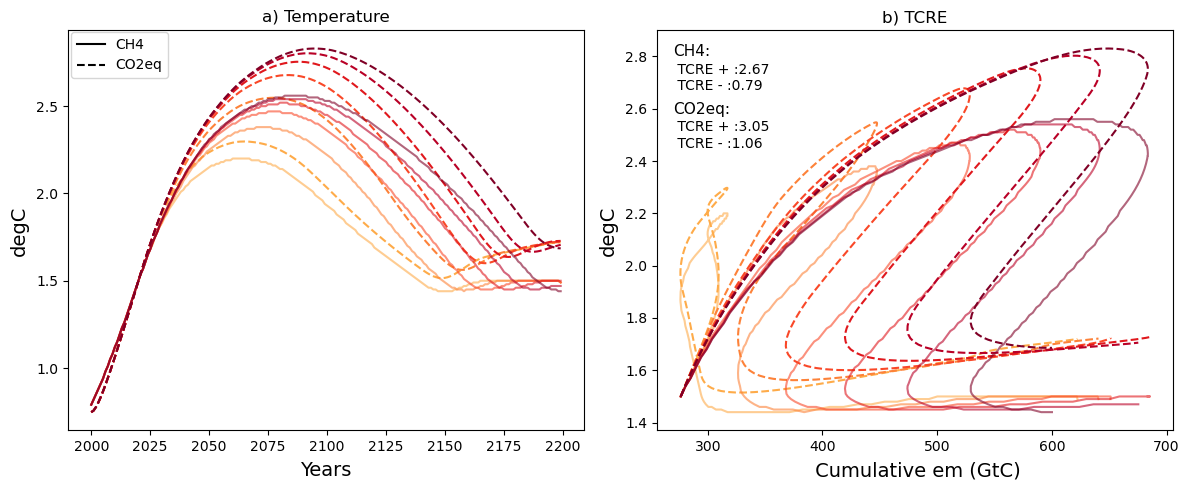

In [170]:

import matplotlib.gridspec as gridspec
%matplotlib inline

## -------------------- PLOT ---------------------##
title = 'ACC2 1.5 degC target CH4 - TCRE, {} emulation'.format(model)

# Plot configuration
width_inch = 12
height_inch = 5

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

# Plot Ratio N/P
# xlabel = 'Overshoot Amount'
# ylabel = 'Ratio'
# xlabelpad = 5
# ylabelpad = 5
# ax = fig.add_subplot(gs[0, 0])
# ax.plot(OS_ch4_15[7:],ratio_ch4_15[7:], marker='o')
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
# ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
# ax.set_title("Ratio N/P emissions")

# Plot TCRE CH4
xlabel = 'Years'
ylabel = 'degC'
xlabelpad = 5
ylabelpad = 5

xlabelpad = 5
ylabelpad = 5

simulations_ch4_feasible = tas_ch4_20_acc2.columns

ax = fig.add_subplot(gs[0, 0])

color = iter(cm.YlOrRd_r(np.linspace(0.6, 0, len(tas_ch4_15_acc2.T))))
for x, item in enumerate(tas_ch4_15_acc2_gwp.columns):
    c = next(color)
    ax.plot(np.arange(2000,2200,1),tas_ch4_15_acc2.iloc[250:450,x],label=simulations_ch4_feasible, color=c, alpha = 0.6)
    ax.plot(np.arange(2000,2200,1),tas_ch4_15_acc2_gwp.iloc[250:450,x],label=simulations_ch4_feasible, color=c, linestyle='dashed')
#ax.annotate("", xytext=(320, 2.05), xy=(440, 2.5), xycoords = 'data', arrowprops=prop)
#ax.annotate("", xytext=(690, 2.25), xy=(600, 1.75), xycoords = 'data', arrowprops=prop)
#ax.legend(overshoot, loc='upper left',title = "OS GtC", title_fontsize = 14, bbox_to_anchor=(0.01, 1), fontsize=10)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
# ax.text(570, 1.8,'TCRE + :4.01\n TCRE - :1.39', wrap = True,  size = 14)
ax.set_title("a) Temperature")

linestyles = ['-', "--"]
dummy_lines = []
for b_idx, b in enumerate(np.arange(2)):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[b_idx])[0])
fig.legend([dummy_lines[i] for i in [0,1]],["CH4","CO2eq"], loc='upper right',bbox_to_anchor=(0.15, 0.94),fontsize=10)


# tas_ch4_15_acc2_gwp = tas_ch4_15_acc2_gwp.subtract(tas_ch4_15_acc2_gwp[2140], axis = 'rows')
# tas_ch4_15_acc2 = tas_ch4_15_acc2.subtract(tas_ch4_15_acc2[2140], axis = 'rows')

ax = fig.add_subplot(gs[0, 1])

xlabel = ' Cumulative em (GtC)'

color = iter(cm.YlOrRd_r(np.linspace(0.6, 0, len(tas_ch4_15_acc2.T))))
for x, item in enumerate(tas_ch4_15_acc2_gwp.columns):
    c = next(color)
    ax.plot(gwpch4cum_15_acc2.iloc[270:450,x], tas_ch4_15_acc2.iloc[270:450,x],label=overshoot, color=c, alpha = 0.6)
    ax.plot(gwpch4cum_15_acc2.iloc[270:450,x], tas_ch4_15_acc2_gwp.iloc[270:450,x],label=overshoot, color=c, linestyle='dashed')
    #ax.annotate("", xytext=(320, 2.05), xy=(440, 2.5), xycoords = 'data', arrowprops=prop)
#ax.annotate("", xytext=(690, 2.25), xy=(600, 1.75), xycoords = 'data', arrowprops=prop)
#ax.legend(overshoot, loc='upper left',title = "OS GtC", title_fontsize = 14, bbox_to_anchor=(0.01, 1), fontsize=10)
ax.text(270, 2.8,'CH4:', wrap = True, size = 11)
ax.text(270, 2.68,' TCRE + :2.67\n TCRE - :0.79', wrap = True, size = 10)

ax.text(270, 2.58,'CO2eq:', wrap = True, size = 11)
ax.text(270, 2.46,' TCRE + :3.05\n TCRE - :1.06', wrap = True, size = 10)

ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
ax.set_title("b) TCRE")

# output file
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path,title.replace(' ','_')) + "_GWP.png"

# save the output file
plt.savefig(output_file)